# Usefull Time series related blogs

## Cointegrated Time-Series and when differencing might be bad

A standard transformation in the time-series analysis toolkit are difference transformations or **difference**. Despite being dead simple, can be quite powerfull. It is quite popular approach whenever some unit-root test significant. While this is fairly safe in the univariate case, things look differently for multivariate time series. 

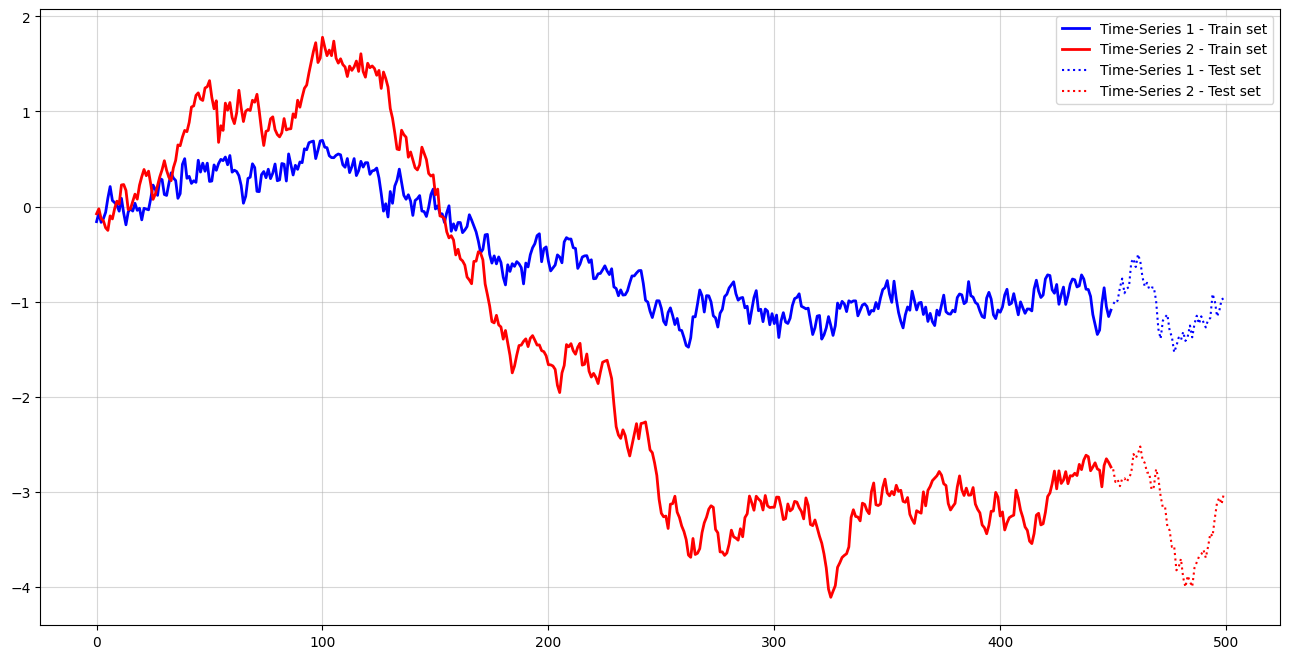

In [4]:
# Example
import numpy as np
import matplotlib.pyplot as plt

A=np.array([[0.2],[-0.3]])
B=np.array([[-0.9],[0.3]])

Atilde=A@B.T

sigma=np.array([[0.1],[0.1]])

np.random.seed(987)

ys = [np.random.normal(size=(2,1))*sigma]

for t in range(500):
    dy=Atilde@ys[-1] + np.random.normal(size=(2,1))*sigma
    ys.append(ys[-1]+dy)

Y = np.concatenate(ys,1).T[1:,:]

Ytrain = Y[:-50,:]
Ytest = Y[-50:,:]

forecast_range = np.arange(len(Ytrain),len(Ytrain)+len(Ytest))

plt.figure(figsize=(16,8))
plt.plot(Ytrain[:,0],c="blue", label="Time-Series 1 - Train set",lw=2)
plt.plot(Ytrain[:,1],c="red", label="Time-Series 2 - Train set",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted", label="Time-Series 1 - Test set")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted", label="Time-Series 2 - Test set")

plt.grid(alpha=0.5)
plt.legend()

There seems to be some connection between both time-series but that might obviously just be a spurious one over time. The next step that you often see done in this setting is to test for unit-roots in both time-series.

An Augmented-Dickey Fuller test from statsmodels shows significance scores of 0.8171 and 0.8512. This underlines the visible unit-roots in both time-series. Thus, the difference transformation appears to be the logical next step. Let’s do that for the train set to forecast the test set further down the line:

Text(0.5, 1.0, 'Time Series 2 - Train set differenced')

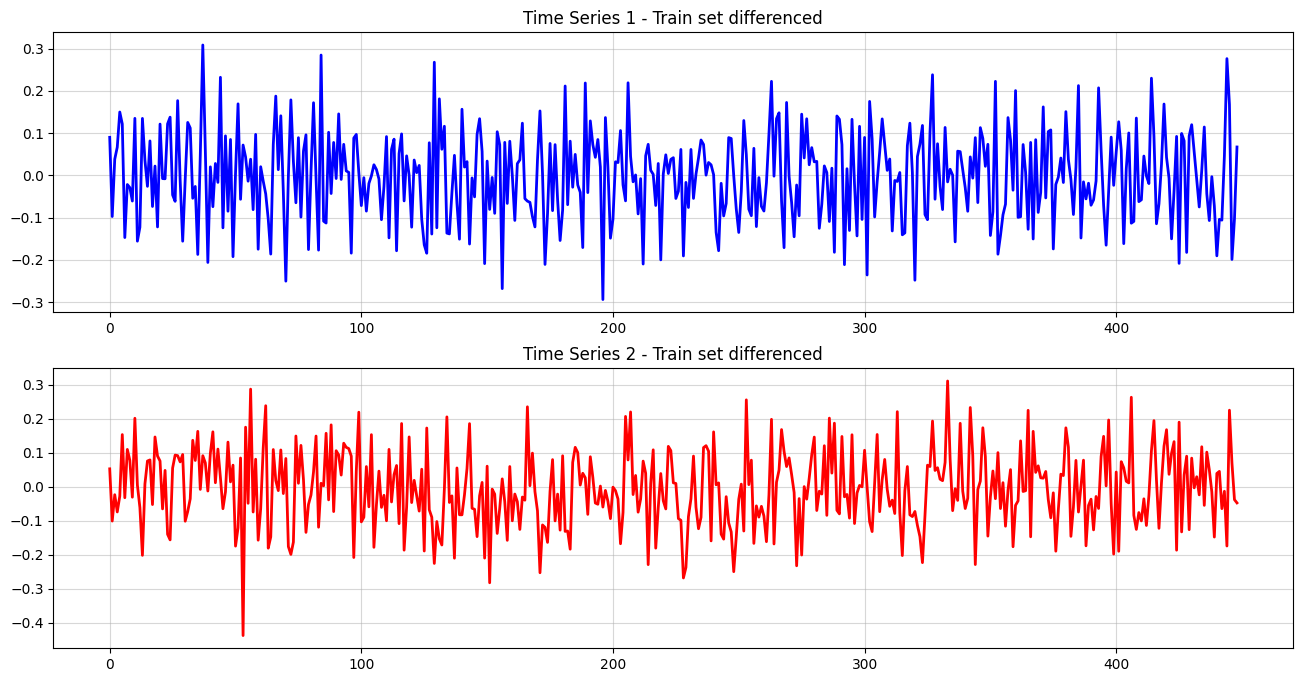

In [5]:
Ytrain_diff = Ytrain[1:,:]-Ytrain[:-1,:]
fig, ax = plt.subplots(2, 1, figsize = (16,8))
ax[0].plot(Ytrain_diff[:,0], c="blue", lw=2)
ax[0].grid(alpha=0.5)
ax[0].set_title("Time Series 1 - Train set differenced")

ax[1].plot(Ytrain_diff[:,1], c="red", lw=2)
ax[1].grid(alpha=0.5)
ax[1].set_title("Time Series 2 - Train set differenced")

Next, we can check forecast performance for two VAR(1) models — one trained on the original time-series and one on the transformed one:

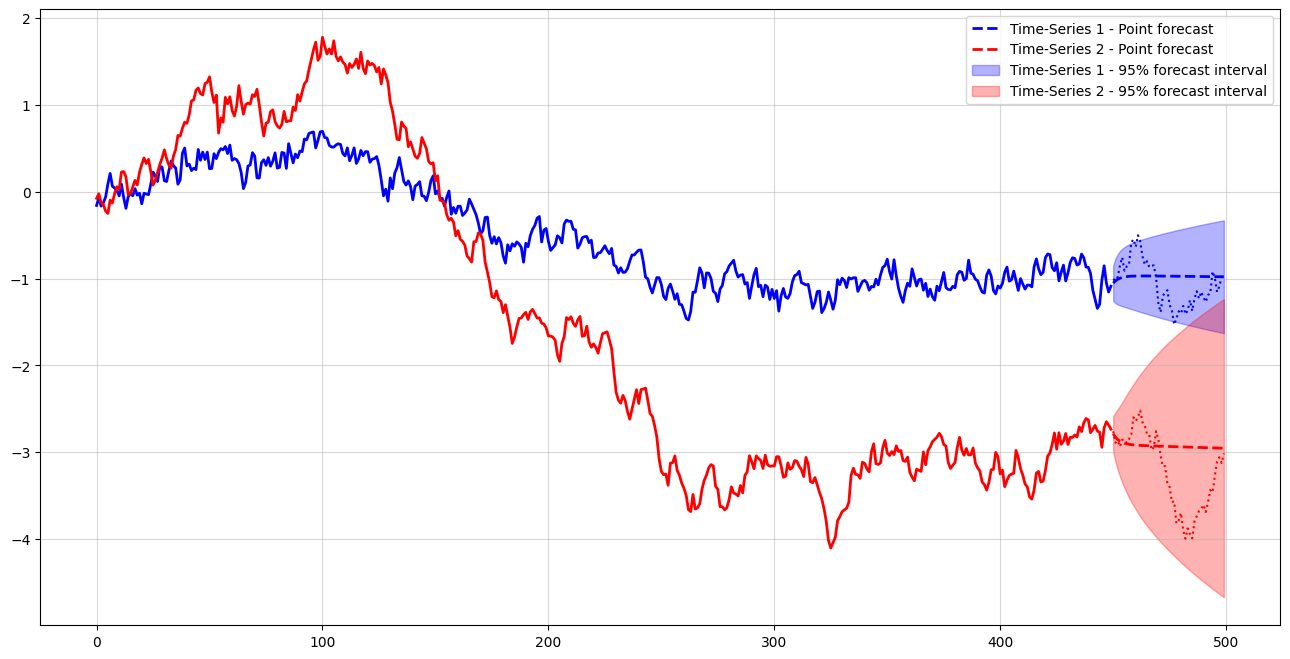

In [6]:
from statsmodels.tsa.api import VAR
from scipy.stats import norm

model_nodiff = VAR(Ytrain).fit(1,trend='n')

pred_mean_nodiff = model_nodiff.forecast(Ytrain,steps=len(Ytest))
pred_std_nodiff = np.sqrt(np.array(list(map(lambda x: np.diag(x),list(model_nodiff.forecast_cov(steps=len(Ytest)))))))
pred_lower_nodiff = norm(pred_mean_nodiff,pred_std_nodiff).ppf(0.025)
pred_upper_nodiff = norm(pred_mean_nodiff,pred_std_nodiff).ppf(0.975)


plt.figure(figsize=(16,8))

plt.plot(Ytrain[:,0],c="blue",lw=2)
plt.plot(Ytrain[:,1],c="red",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted")

plt.plot(forecast_range, pred_mean_nodiff[:,0],c="blue",ls="dashed",lw=2, label="Time-Series 1 - Point forecast")
plt.plot(forecast_range, pred_mean_nodiff[:,1],c="red",ls="dashed",lw=2, label="Time-Series 2 - Point forecast")
plt.fill_between(forecast_range, pred_lower_nodiff[:,0], pred_upper_nodiff[:,0],color="blue",alpha=0.3,label="Time-Series 1 - 95% forecast interval")
plt.fill_between(forecast_range, pred_lower_nodiff[:,1], pred_upper_nodiff[:,1],color="red",alpha=0.3,label="Time-Series 2 - 95% forecast interval")

plt.grid(alpha=0.5)
plt.legend()

The summed MSE over both time-series forecasts is at 0.3463. Clearly, the model with training data differenced should perform better:

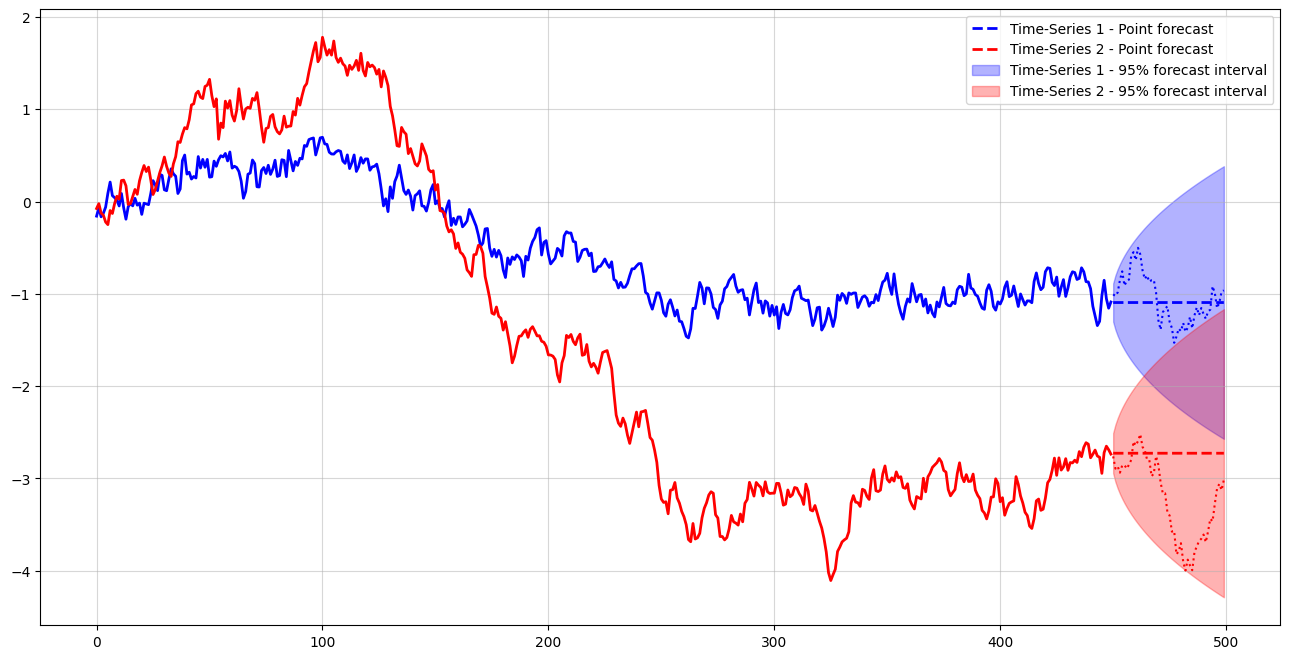

In [7]:
model_diff = VAR(Ytrain_diff).fit(1,trend='n')

pred_mean_diff = Ytrain[-1,:].reshape(1,-1)+np.cumsum(model_diff.forecast(Ytrain_diff,steps=len(Ytest)),0)
pred_std_diff = np.sqrt(np.cumsum(np.array(list(map(lambda x: np.diag(x),list(model_diff.forecast_cov(steps=len(Ytest)))))),0))
pred_lower_diff = norm(pred_mean_diff,pred_std_diff).ppf(0.025)
pred_upper_diff = norm(pred_mean_diff,pred_std_diff).ppf(0.975)


plt.figure(figsize=(16,8))

plt.plot(Ytrain[:,0],c="blue",lw=2)
plt.plot(Ytrain[:,1],c="red",lw=2)
plt.plot(forecast_range, Ytest[:,0],c="blue", ls="dotted")
plt.plot(forecast_range, Ytest[:,1],c="red", ls="dotted")

plt.plot(forecast_range, pred_mean_diff[:,0],c="blue",ls="dashed",lw=2, label="Time-Series 1 - Point forecast")
plt.plot(forecast_range, pred_mean_diff[:,1],c="red",ls="dashed",lw=2, label="Time-Series 2 - Point forecast")
plt.fill_between(forecast_range, pred_lower_diff[:,0], pred_upper_diff[:,0],color="blue",alpha=0.3,label="Time-Series 1 - 95% forecast interval")
plt.fill_between(forecast_range, pred_lower_diff[:,1], pred_upper_diff[:,1],color="red",alpha=0.3,label="Time-Series 2 - 95% forecast interval")

plt.grid(alpha=0.5)
plt.legend()

This time, the summed MSE is 0.5105 - approximately 50% higher. Also, the forecast interval for time-series 1 is much larger than without any differencing. Something seems to be off with the popular difference transformation.

### Why cointegration matters

Right now, you might — rightfully — argue that the underperformance of the differencing model was due to pure chance. Indeed, we would need much broader experiments to verify our initial claim empirically.

It is, however, possible to actually prove why differencing can be bad for multivariate time-series analysis. To do so, let us take a step back to univariate time-series models and why difference transformations work here.

We will only look at AR(1) and VAR(1) time-series for simplicity. All results can be shown to hold for higher-order AR/VAR, too.

### Unit-Root AR(1) time series -- when differencing is likely safe

Mathematically, an AR(1) time-series looks as follows:

$$ y_{t} = \phi_{1}y_{t-1} + \epsilon_{t} $$
$$ \epsilon_{t} \sim N(0,\sigma^{2}) $$

In order for differencing to make sense, we need the time-series to have a unit root. This is the case when solution of characteristic polynomial:

$$ 1 - \phi_{1}z = 0 $$

The only choice for the AR-parameter is therefore:

$$ \phi_{1} = 1 $$

and thus: 

$$ y_{t} = y_{t-1} + \epsilon_{t} $$

In order to make this equation stationary, we subtract the lagged variable from both sides:

$$ y_{t} - y_{t-1} = y_{t-1} - y_{t-1} + \epsilon_{t} $$
$$ y_{t} - y_{t-1} = y_{t-1} - y_{t-1} + \epsilon_{t} $$
$$ \Delta y_{t} = \epsilon_{t} $$


Clearly, the best possible forecast now is to predict white noise. Keep in mind that we could equally well fit a model on the untransformed variable. However, the differenced time-series directly uncovers the lack of any truly autoregressive component.

On the one hand, differencing is clearly a good choice in univariate time-series with unit-roots. Things are not as simple for multivariate time-series, though.


### Multivariate time-series with cointegration
Consider now a VAR(1) time where we replace the scalars in the AR(1) model with vectors (bold, lower-case) and vectors (upper case):

$$ y_{t} = A*y_{t-1} + u_{t}$$
$$ u_{t} \sim N(0,\Sigma) $$

A unit-root in a VAR(1) time-series imply, similarly to the AR(1) case, that

$$ det(I - A) = 0$$


In the trivial case, the autoregression parameter is the identity matrix. This implies that the marginals in our VAR(1) time-series are all independent and unit-root. If we exclude this case and proceed as for AR(1), we get

$$ y_{t} - y_{t-1} = A*y_{t-1} - y_{t-1} + u_{t} $$
$$ \Delta y_{t} = -(I-A)y_{t-1} + u_{t} $$
$$ \Delta y_{t} = \hat{A}*y_{t-1} + u_{t} $$

The last line is also called an Vector Error Correcting Representation of a VAR time-series. If you scroll back to our simulation, this is the exact formula that was used to generate the time-series.

By making Atilde rank-deficient, the time-series becomes cointegrated, as explained by Lütkepohl.

Clearly, a cointegrated VAR(1) time-series differs from the univariate AR(1) case. Even after differencing, the transformed values depend on the past of the original time-series. We would therefore lose important information if we don’t account for the original time-series anymore.

If you are working with multivariate data, you should therefore not just blindly apply differencing.


### How to deal with cointegration

The above result begs the question of what we should do to handle cointegration. Typically, time-series analysis is concerned either with forecasting or inference. Therefore, two different approaches come to mind:
- **Cross-validation and backtesting** — the pragmatic, ‘data sciency’ approach. If our goal is primarily to build the most accurate forecast, we don’t necessarily need to detect cointegration at all. As long as the resulting model is performant and reliable, nearly anything goes. As usually, the ‘best’ model can be selected based on cross-validation and out-of-sample performance tests. The primary implication from cointegration is then to apply differencing with some care. On the other hand, the above result also suggests that adding the original time-series as a feature might be a good idea in general.
- **Statistical tests** — the classical statistics way. Obviously, cointegration is nothing new to econometricians and statisticians. If you are interested in learning about the generating process itself, this approach is likely mo r e expedient.

## Anomaly Detection using VAR

Anomaly detection is a hot topic in machine learning. In time series applications, when we face this kind of problem, we have to take into account also the temporal dimension. The history of a series contains a lot of information on it's behavior and can suggest it's future changes. This is particularly true for series not generated by a random walk process and that exhibits/periodic pattern. 

We introduce a methodoly to detect anomaly in a complex system made by multiple correlated series. We use **VAR** models, the multivariate extension of ARIMA, to extract the correlation pattern from the series at our disposal. The learned information by VAR is then used to build a threshold mechanism to flag alerts when our metric exceeds a critical value.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

In [2]:
train_hours = 80*7*24  # weeks x hours x days
test_hours = 15*7*24  # weeks x hours x days

df = pd.read_csv('bike-and-ped-counter.csv.zip', nrows=train_hours+test_hours, parse_dates=['Date'])

print(df.shape)
df.head()

(15960, 6)


Date  BGT North of NE 70th Total  Ped South  Ped North  \
0 2014-01-01 00:00:00                        15.0        0.0        2.0   
1 2014-01-01 01:00:00                         9.0        1.0        0.0   
2 2014-01-01 02:00:00                         9.0        0.0        0.0   
3 2014-01-01 03:00:00                        19.0        0.0        0.0   
4 2014-01-01 04:00:00                        19.0        0.0        0.0   

   Bike North  Bike South  
0         2.0        11.0  
1         1.0         7.0  
2         0.0         9.0  
3         0.0        19.0  
4         0.0        19.0

In [3]:
df['Ped South'] = df['Ped South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Ped North'] = df['Ped North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike South'] = df['Bike South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike North'] = df['Bike North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['BGT North of NE 70th Total'] = df['Ped South'] + df['Ped North'] + df['Bike South'] + df['Bike North']

df['Date'] = pd.to_datetime(df['Date'].dt.date)

In [4]:
### DAILY AGGREGATION ###

df_day = pd.DataFrame()
df_day['Ped South'] = df.groupby(df.Date)['Ped South'].sum()
df_day['Ped North'] = df.groupby(df.Date)['Ped North'].sum()
df_day['Bike South'] = df.groupby(df.Date)['Bike South'].sum()
df_day['Bike North'] = df.groupby(df.Date)['Bike North'].sum()
df_day['Total'] = df.groupby(df.Date)['BGT North of NE 70th Total'].sum()

df_day.index = pd.DatetimeIndex(df_day.index.values, freq=df_day.index.inferred_freq)

<AxesSubplot: >

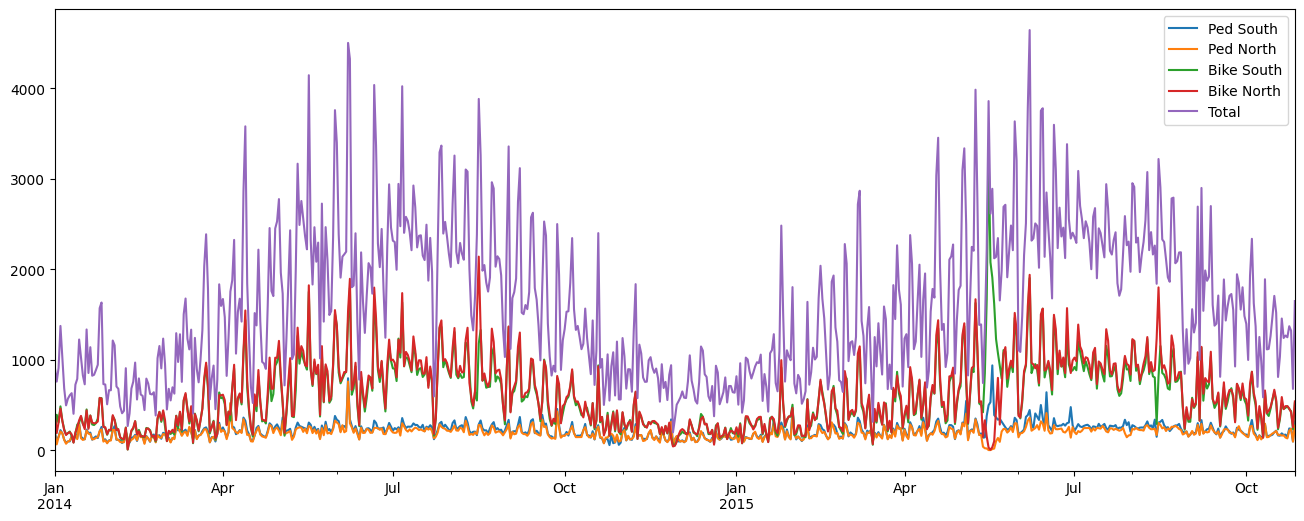

In [5]:
### PLOT DAILY DATA ###

df_day.plot(figsize=(16,6))

In [6]:
### TRAIN SPLIT ###

train = df_day[:(train_hours//24)].copy()

train.shape

(560, 5)

### Univariate Anomaly Detection

In the univariate anomaly approach, we plan to use ARIMA to detect the presence of strange patterns. We decide to focus on the series of total counts. The first thing to deal with when developing ARIMA is to take care of stationarity, explosive trends, or seasonality. As we can easily check on the plot above and the autocorrelation below, the total count series presents a double seasonality: weekly and yearly.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

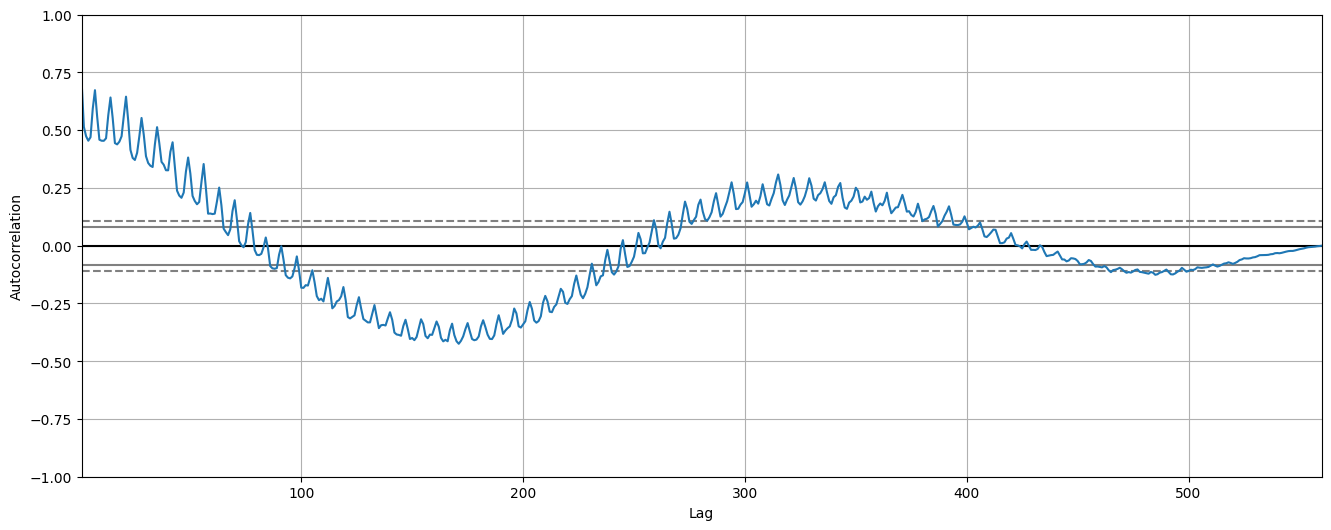

In [7]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['Total'])

The long term seasonality can be very annoying. To remove it we subtract on each day the relative monthly mean computed on train data. In this way, we remain with only the weekly pattern which can be learned by our models without much problem.

In [8]:
### MONTHLY TRAIN MEAN ###

month_mean_train = train.groupby(train.index.month).mean()

### REMOVE LONG TERM SEASONALITY FROM TRAIN ###

train['Ped South'] = train.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
train['Ped North'] = train.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
train['Bike South'] = train.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
train['Bike North'] = train.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)
train['Total'] = train.apply(lambda x: x['Total'] - month_mean_train['Total'][x.name.month], axis=1)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

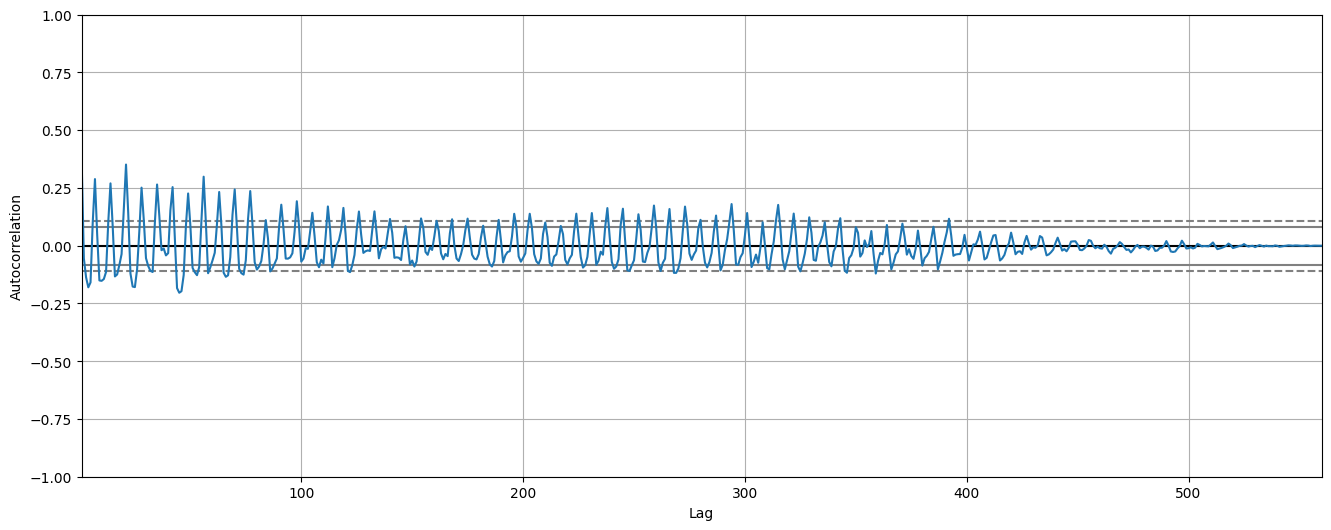

In [9]:
### TOTAL COUNT TRAIN AUTOCORR ###

plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['Total'])

We fit the best ARIMA limiting the search around 7 autoregressive order while minimizing AIC. The final model seems to produce normal residuals without any autocorrelation degree.

In [10]:
### TRAIN TEST SPLIT IN UNIVARIATE CASE ###

train_uni = train['Total'].copy()
test_uni = df_day['Total'][(train_hours//24):].copy()
test_uni = test_uni - test_uni.index.month.map(month_mean_train['Total'])

train.drop('Total', inplace=True, axis=1)

In [11]:
### FIND BEST UNIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for p in range(6,9):
    for q in range(0,10):

        mod = SARIMAX(train_uni, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            AIC[(p,0,q)] = res.aic
        except:
            AIC[(p,0,q)] = np.inf
            
        if AIC[(p,0,q)] < best_aic:
            best_aic = AIC[(p,0,q)]
            best_order = (p,0,q)
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (6, 0, 5) BEST AIC: 8525.443612669904


In [12]:
### TRAIN BEST UNIVARIATE MODEL ###

mod = SARIMAX(train_uni, order=best_order, enforce_invertibility=False)
res = mod.fit(disp=False)
res.aic

8525.443612669904

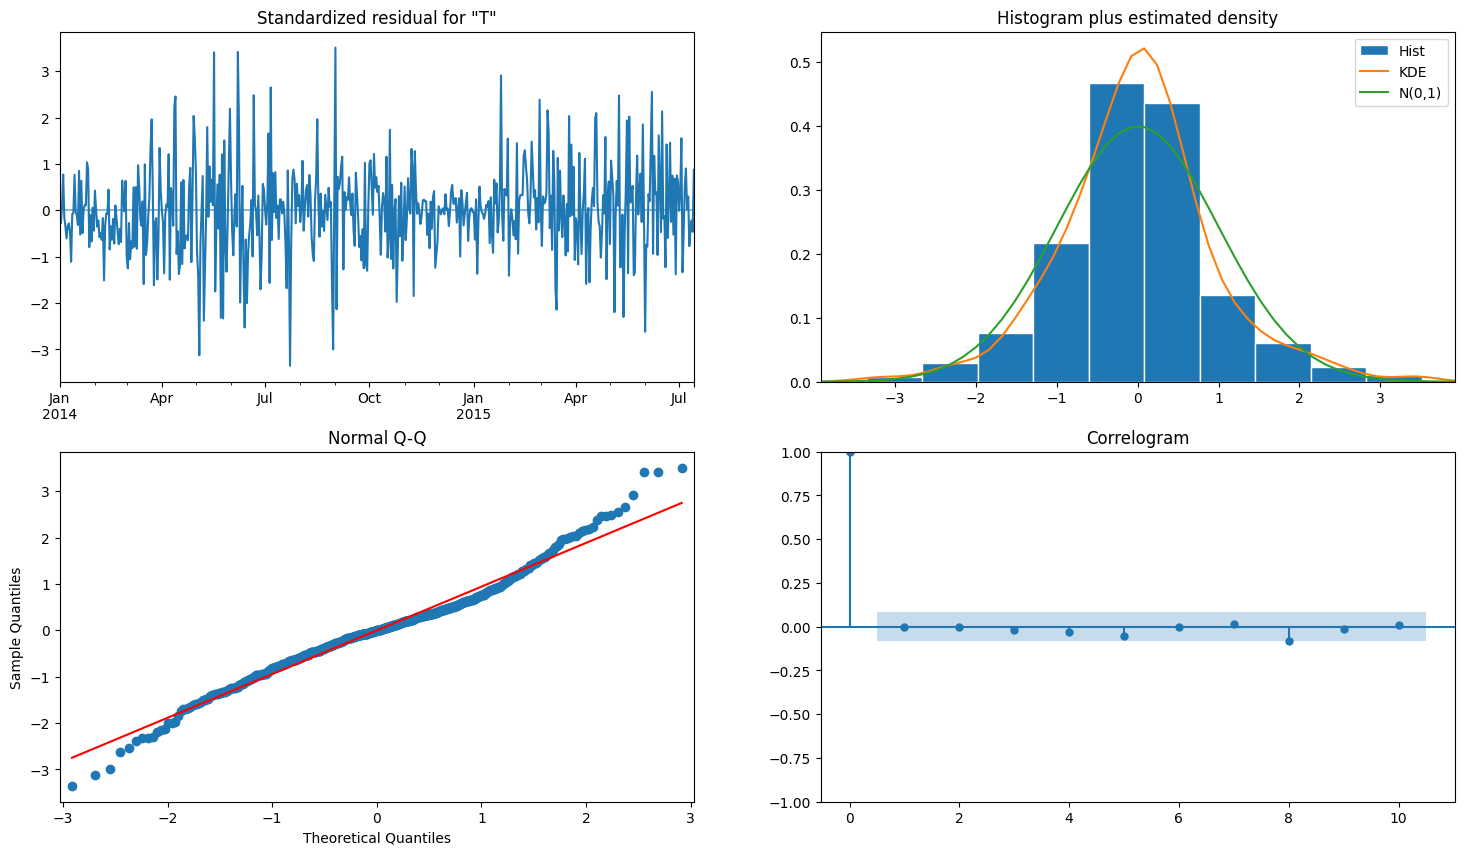

In [13]:
### PERFORMANCE OPTINAL MODEL ###

res.plot_diagnostics(figsize=(18,10))
plt.show()

In [14]:
### GET TRAIN FITTED VALUES ###

predict = res.get_prediction()
predicted_mean = predict.predicted_mean + predict.predicted_mean.index.month.map(month_mean_train['Total'])
train_uni = train_uni + train_uni.index.month.map(month_mean_train['Total'])
predict_ci = predict.conf_int(alpha=0.1)
predict_ci['lower Total'] = predict_ci.apply(lambda x: x['lower Total'] + month_mean_train['Total'][x.name.month], axis=1)
predict_ci['upper Total'] = predict_ci.apply(lambda x: x['upper Total'] + month_mean_train['Total'][x.name.month], axis=1)

residuals_mean = res.resid.mean()
residuals_std = res.resid.std()

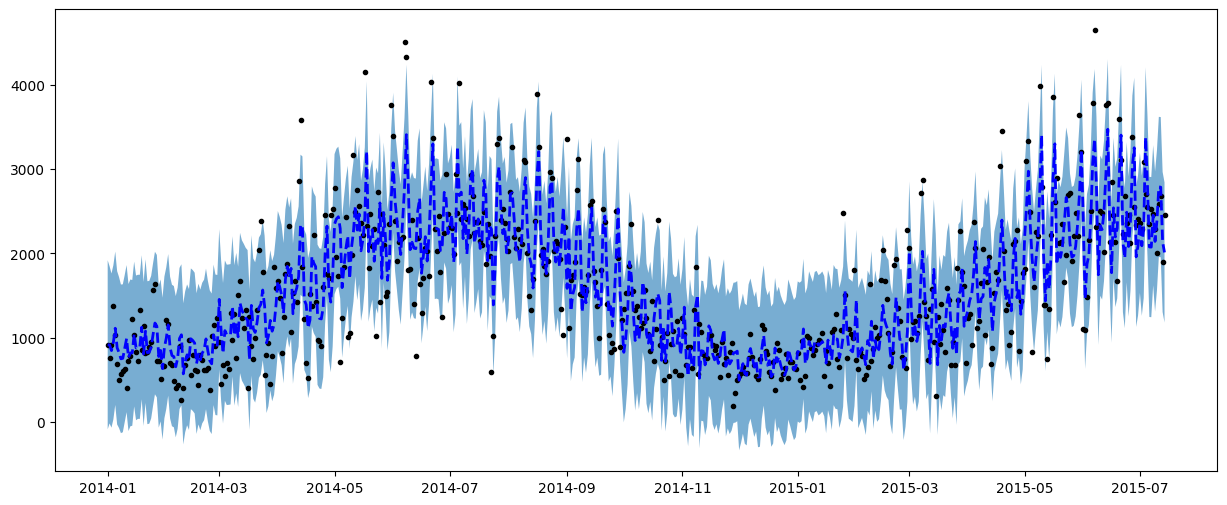

In [15]:
### PLOT TRAIN FITTED VALUES ###

plt.figure(figsize=(15,6))

plt.plot(train_uni, 'k.')
plt.plot(predicted_mean, linestyle='--', linewidth=2, color='blue')
plt.fill_between(predict_ci.index, predict_ci['lower Total'], predict_ci['upper Total'], alpha=0.6)

In [16]:
### ITERATIVE PREDICTIONS ON TEST DATA ###

point_forecast = res.get_prediction(end=mod.nobs)
point_ci = point_forecast.conf_int(alpha=0.1)

mean_pred = {point_forecast.predicted_mean.index[-1]: point_forecast.predicted_mean[-1]}
upper_pred = {point_ci.index[-1]: point_ci['upper Total'][-1]}
lower_pred = {point_ci.index[-1]: point_ci['lower Total'][-1]}

for t,row in test_uni[:-1].iteritems():
    
    row = pd.Series(row, index=[t])
    res = res.extend(row)
    point_forecast = res.get_prediction(1)
    point_ci = point_forecast.conf_int(alpha=0.1)
    
    mean_pred[point_forecast.predicted_mean.index[0]] = point_forecast.predicted_mean.values[0]
    upper_pred[point_ci.index[0]] = point_ci['upper Total'][0]
    lower_pred[point_ci.index[0]] = point_ci['lower Total'][0]
    
mean_pred = pd.Series(mean_pred)
upper_pred = pd.Series(upper_pred)
lower_pred = pd.Series(lower_pred)

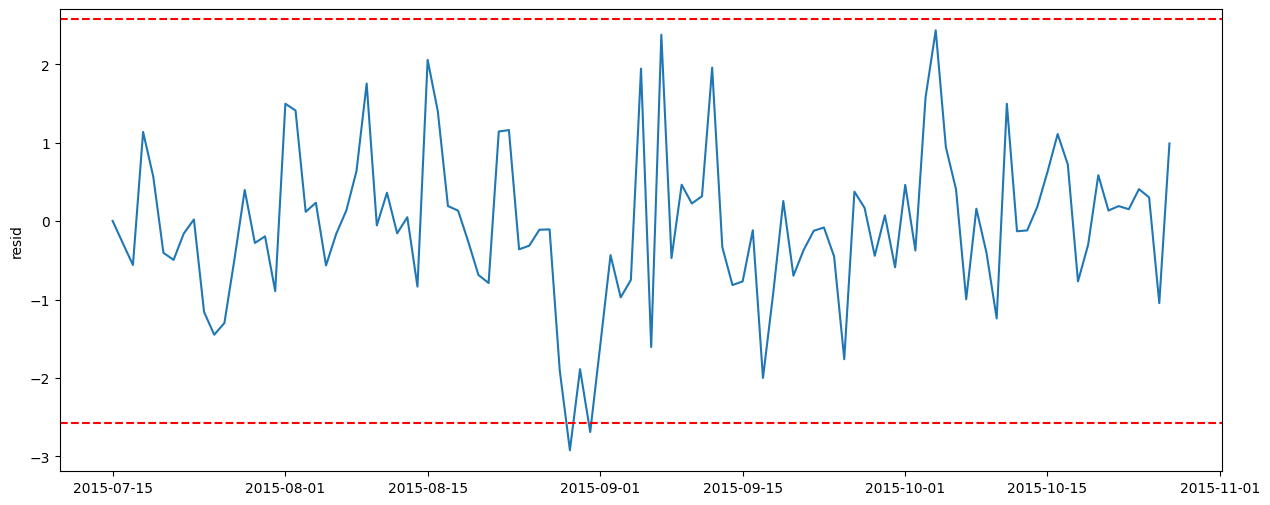

In [17]:
### TEST RESIDUALS ANALYSIS ###

alpha = 0.01
upper = stats.norm.ppf(1 - alpha/2)
lower = stats.norm.ppf(alpha/2)

residuals_test = test_uni - residuals_mean
residuals_test = (residuals_test - residuals_mean) / residuals_std

plt.figure(figsize=(15,6))
plt.plot(residuals_test)
plt.ylabel('resid')
plt.axhline(upper, c='red', linestyle='--')
plt.axhline(lower, c='red', linestyle='--')

With the ARIMA fitted we are ready to search for anomalies. We have 2 possibilities available: we can identify as anomaly every observation outside the confidence intervals or we can look at the residuals. Each procedure requires to produce iterative predictions and to evaluate each time our forecast with the actual value.

In [18]:
### REVERSE SCALING TEST ITERATIVE PREDICTIONS ###

mean_pred = mean_pred + mean_pred.index.month.map(month_mean_train['Total'])
upper_pred = upper_pred + upper_pred.index.month.map(month_mean_train['Total'])
lower_pred = lower_pred + lower_pred.index.month.map(month_mean_train['Total'])
test_uni = test_uni + test_uni.index.month.map(month_mean_train['Total'])

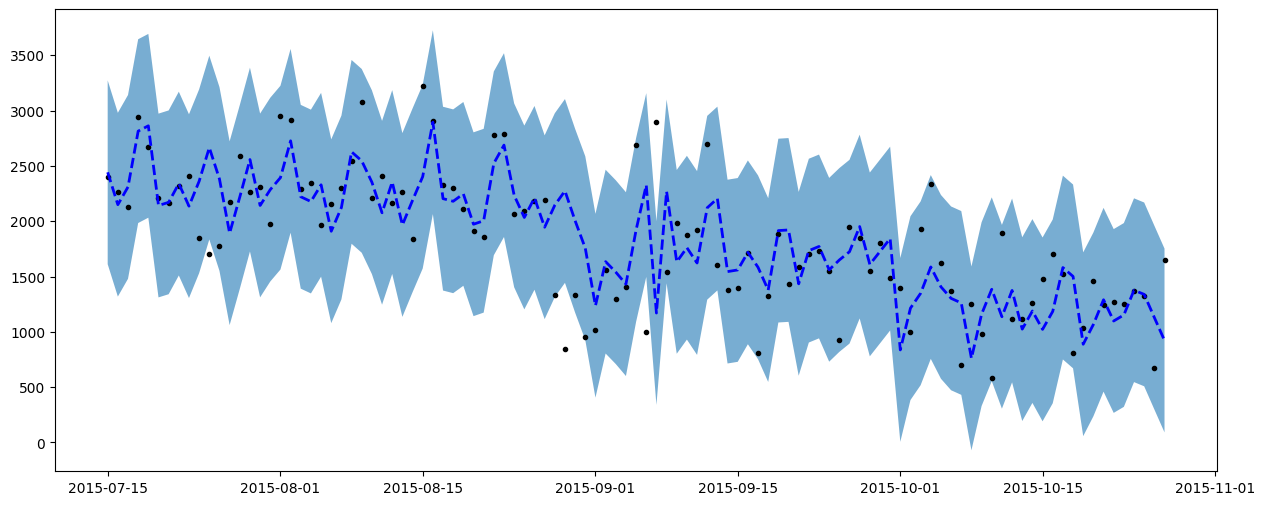

In [19]:
### PLOT TEST ITERATIVE PREDICTIONS ###

plt.figure(figsize=(15,6))

plt.plot(test_uni, 'k.')
plt.plot(mean_pred, linestyle='--', linewidth=2, color='blue')
plt.fill_between(mean_pred.index, lower_pred, upper_pred, alpha=0.6)

### Multivariate Anomaly Detection

The multivariate generalization of the previous approach involves the adoption of the VAR model. VAR model extends the univariate autoregressive (AR) model by capturing the linear relations between multiple variables. For each input series, a regression is carried out. The original variables are regressed against their own lagged values and the lagged values of other variables. For our multivariate task, we take into account both bike and pedestrian series.

In a multivariate process system with the presence of serial correlation, we use VAR models to approximate the system and monitor the residuals as a serially independent series. Using a VAR to approximate a linear system is appropriate due to the physical principles of the process dynamics.

VAR training is computed as before selecting the best order minimizing AIC. The data are standardized in the same way to remove the long term seasonality. Not surprisingly the best model is a VAR(7). After testing the independence and normality of residual data, a Hotelling’s T-squared statistic can be computed to detect the early presence of anomalies:


$$ T_{i}^{2} = \hat{e_{i}}^{'} \Sigma^{-1} \hat{e_{i}} \sim X^{2} $$

The application of the T-squared control chart is conducted in two phases: the control limit establishment phase, and the monitoring phase. The first phase focuses on obtaining model residuals so that the calculated control limit can be used in phase two for monitoring the residual process of future anomalies. The control limit for the T-squared control chart is given by:

$$ UCL = {p(n+1)(n-1) \over n(n-p)} F_{\alpha,p,n-p} $$

Where F represents an F distribution with p and n-p degrees of freedom and alpha significance level. If T2 > UCL, then stop and investigate. The estimated Sigma obtained at the end of phase 1 (together with residuals mean and standard deviation) is used to calculate the T-squared statistic for each new observation.

In [20]:
### FIND BEST MULTIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 7 BEST AIC: 34.896281239608705


In [21]:
### TRAIN BEST MULTIVARIATE MODEL ###

var = VAR(endog=train)
var_result = var.fit(maxlags=best_order)

var_result.aic

34.896281239608705

In [22]:
### COMPUTE TRAIN T2 METRIC ###

residuals_mean = var_result.resid.values.mean(axis=0)
residuals_std = var_result.resid.values.std(axis=0)

residuals = (var_result.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))

In [23]:
### COMPUTE UCL ###

m = var_result.nobs
p = var_result.resid.shape[-1]
alpha = 0.01

UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) *(p*(m+1)*(m-1)/(m*m-m*p))
UCL

13.511575593053317

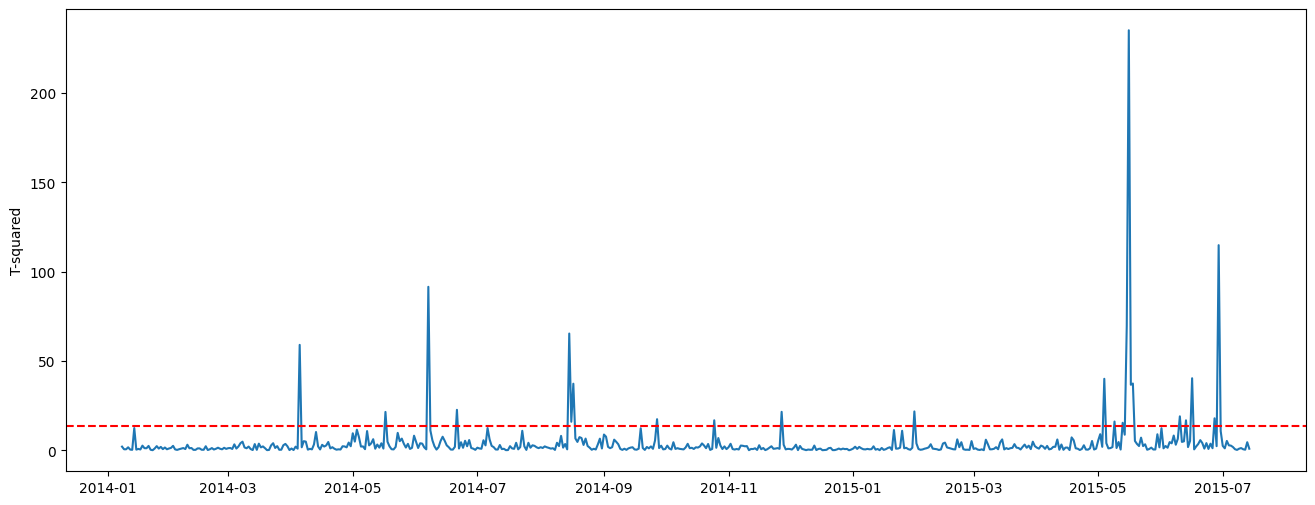

In [24]:
### PLOT TRAIN T2 METRIC ###

plt.figure(figsize=(16,6))
plt.plot(train.index[best_order:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [25]:
### TEST SPLIT IN MULTIVARIATE CASE ###

test = df_day[(train_hours//24-best_order):].copy()
test.drop('Total', inplace=True, axis=1)

test.shape

(112, 4)

In [26]:
### REMOVE LONG TERM SEASONALITY FROM TEST ###

test['Ped South'] = test.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
test['Ped North'] = test.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
test['Bike South'] = test.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
test['Bike North'] = test.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)

In [27]:
### ITERATIVE PREDICTIONS ON TEST DATA ###

pred = []

for i in range(best_order, len(test)):
    
    pred.append(var_result.forecast(test.iloc[i-best_order:i].values, steps=1))
    
pred = np.vstack(pred)
pred.shape

(105, 4)

In [28]:
### COMPUTE TEST T2 METRIC ###

residuals_test = test.iloc[best_order:].values - pred
residuals_test = (residuals_test - residuals_mean) / residuals_std

T_test = np.diag((residuals_test).dot(cov_residuals).dot(residuals_test.T))

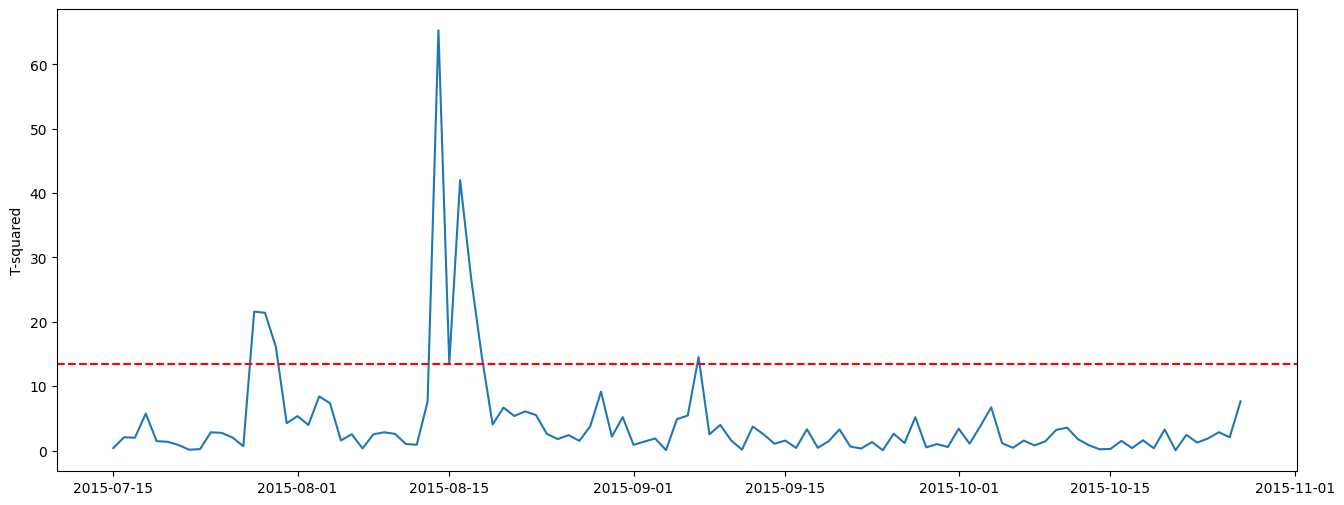

In [29]:
### PLOT TEST T2 METRIC ###

plt.figure(figsize=(16,6))
plt.plot(test.iloc[best_order:].index, T_test)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

## Real-Time Time Series Anomaly Detection

As much as it has become easier over the years to collect vast amounts of data across different sources, companies need to ensure that the data they’re gathering can bring value. To aid insight collection from the data, machine learning and analytics have become trending tools. Since these domains require real-time insights, an abundance of unwelcome data can create real issues.

Before decisions are made, and critically, before actions are taken, we must ask: are there anomalies in our data that could skew the results of the algorithmic analysis? If anomalies do exist, it is critical that we automatically detect and mitigate their influence. This ensures that we get the most accurate results possible before taking action.

In this post, we explore different anomaly detection approaches that can scale on a big data source in real-time. The **tsmoothie** package can help us to carry out this task. **Tsmoothie** is a python library for time series smoothing and outlier detection that can handle multiple series in a vectorized way. It’s useful because it can provide the techniques we needed to monitor sensors over time.

### Types of anomalies:

Anomalies are often divided into point and pattern anomalies. **Point anomalies** are single instances of something abnormal, while **pattern anomalies** represent clusters of data that are abnormal.

In most of the case, some point anomalies may seem like a case of bad luck. With a pattern anomaly instead, the data creates a pattern that looks very different from normal. Pattern anomalies are more difficult to detect because we must first be able to define a normal pattern, and then we could need more data to be able to classify that this pattern is anomalous compared to historical activity.

### Point Anomalies

Our aim here is to detect data points that deviate so much from others. This arouses suspicions that the points were generated by a different mechanism.

Two different algorithms are used: a convolutional smoother and an exponential smoother. Both smooth the received signals using a sliding window approach. The convolution approach uses a discrete linear convolution while the exponential one uses an exponentially weighted convolution. Convolution is a mathematical operation that could be described as the integral of the product of two sequences: the raw signal and the weights. The convolutional smoother uses weights generated using predefined windows function (linear, hanning, hamming, bartlett, blackman). In the case of linear type, the weights are all the same and equal to one. This makes the operation equal to a moving average. The exponential smoother uses weights generated with an exponential function. As result, the most recent observations weight the most when computing the smoothing.

Respectively, two different data structures are taken into account: random walks series and seasonal series with no trend.

When a new value is collected, the smoothing is computed. The differences between the real observations and the corresponding smoothed values are known as residuals. We use them to define the outliers or anomalies as the points where the real observations exceed the residuals’ confidence bands.

From the simulations, we can see that our approaches are able to detect peaks and insane values which can be classified as point anomalies.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

In [32]:
### UTILITY FUNCTION FOR PLOTTING ###

def plot_history(ax, i, is_anomaly, window_len, color='blue', **pltargs):
    
    posrange = np.arange(0,i)
    
    ax.fill_between(posrange[window_len:], 
                    pltargs['low'][1:], pltargs['up'][1:], 
                    color=color, alpha=0.2)
    if is_anomaly:
        ax.scatter(i-1, pltargs['original'][-1], c='red')
    else:
        ax.scatter(i-1, pltargs['original'][-1], c='black')
    ax.scatter(i-1, pltargs['smooth'][-1], c=color)
    
    ax.plot(posrange, pltargs['original'][1:], '.k')
    ax.plot(posrange[window_len:], 
            pltargs['smooth'][1:], color=color, linewidth=3)
    
    if 'ano_id' in pltargs.keys():
        if pltargs['ano_id'].sum()>0:
            not_zeros = pltargs['ano_id'][pltargs['ano_id']!=0] -1
            ax.scatter(not_zeros, pltargs['original'][1:][not_zeros], 
                       c='red', alpha=1.)

In [33]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 200

data = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                      process_noise=10, measure_noise=30)

data.shape

(3, 200)

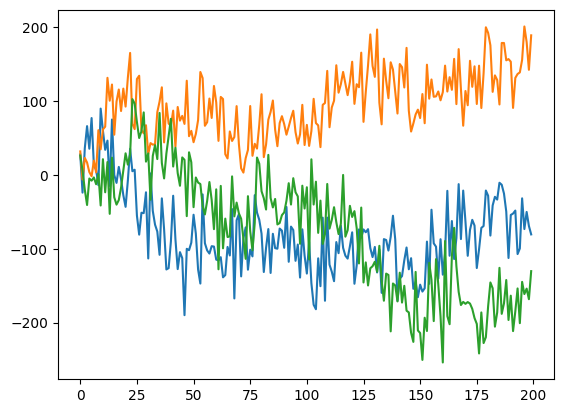

In [34]:
plt.plot(data.T)
np.set_printoptions(False)

In [36]:
### SLIDING WINDOW PARAMETER ###

window_len = 20

In [37]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])

    
print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation1.gif')
plt.close(fig)
print('DONE')

100%|██████████| 201/201 [01:22<00:00,  2.44it/s]


CREATING GIF...
DONE


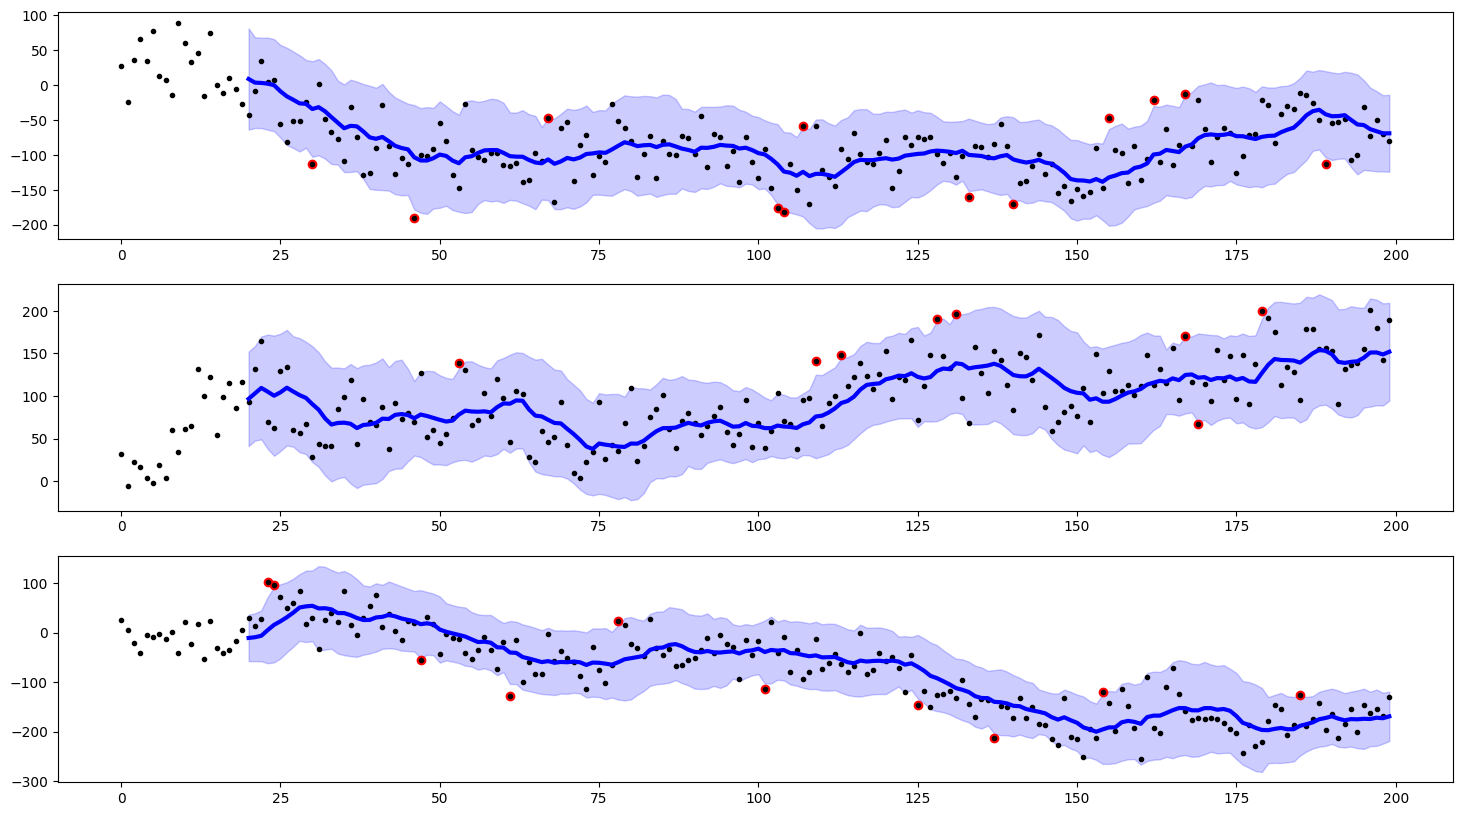

In [38]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
   
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

In [39]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 200

data = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                         freq=24, measure_noise=20, amp=[30,40,50])

data.shape

(3, 200)

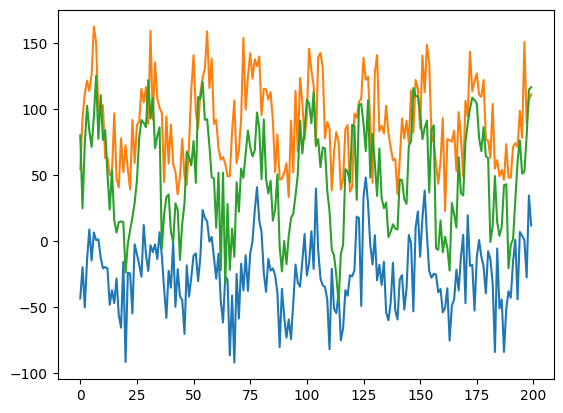

In [40]:
plt.plot(data.T)
np.set_printoptions(False)

In [41]:
### SLIDING WINDOW PARAMETER ###

window_len = 20

In [42]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = ExponentialSmoother(window_len=window_len//2, alpha=0.4)
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
    
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation2.gif')
plt.close(fig)
print('DONE')

100%|██████████| 201/201 [01:04<00:00,  3.13it/s]


CREATING GIF...
DONE


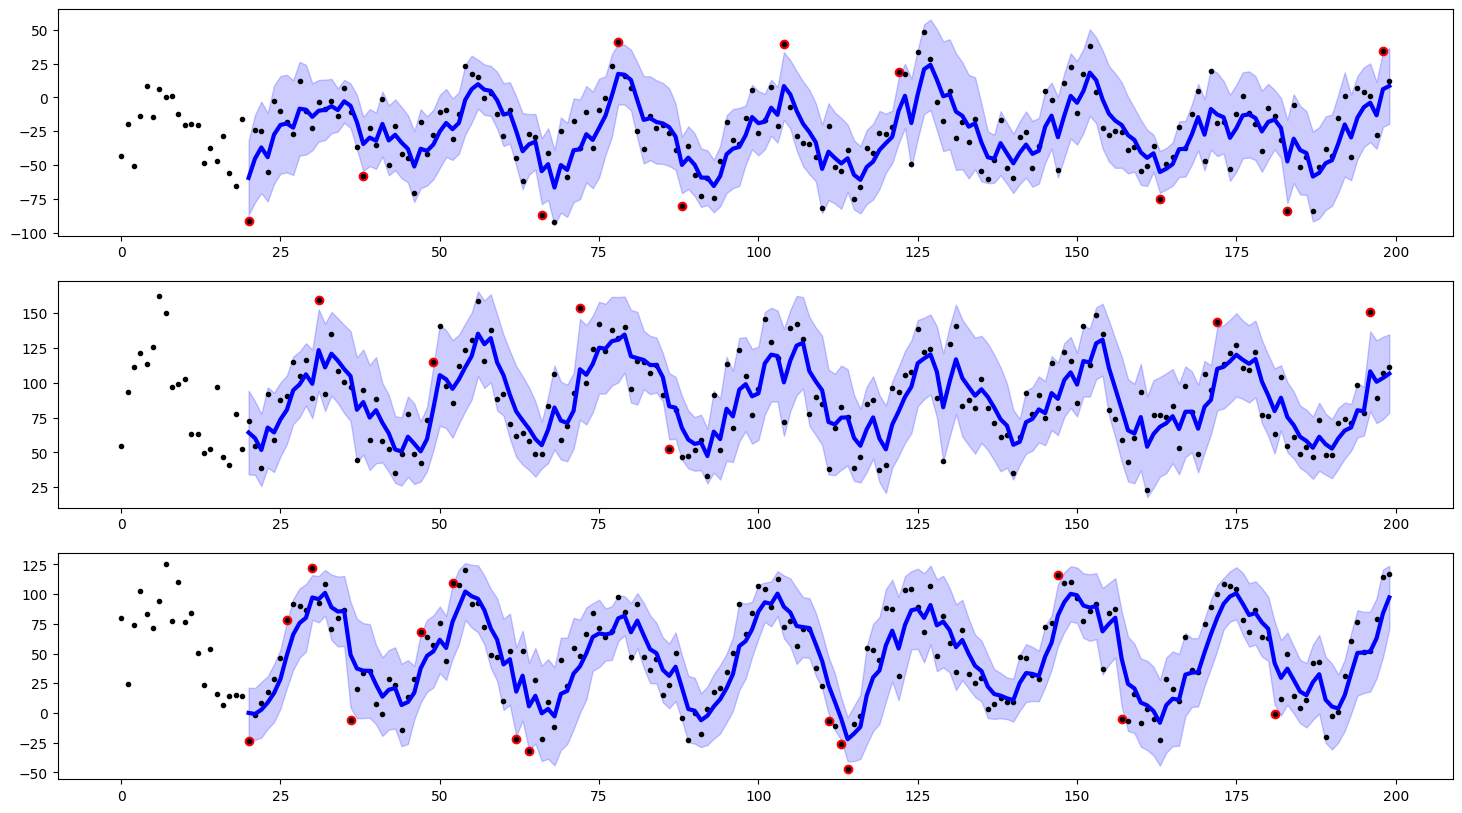

In [43]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

### Pattern Anomalies

Our aim here is to detect a continuous set of data points that are collectively anomalous even though the individual points may or may not be point anomalies. When we are looking for pattern anomalies the underlying assumption is that the raw data must show a pattern. This is the case, for example, of seasonal time series.

Seasonality in time series is commonly observed in a lot of data. Studying the seasonal component is critical for effective anomaly detection. In this regard, a key challenge is how to determine the seasonal period and separate it from trends. Seasonal-Trend-Decomposition is one of the commonly used approaches for detecting seasonal and trend components. Convolution filtering, LOWESS, or natural-cubic-spline are the techniques used by tsmoothie to detect a trend component. While seasonal patterns are detected using a mean aggregation in the periods. From the union of the extracted trend and the observed seasonalities, we can build an hypothetical time series of smoothed values.

Seasonal series with trends are taken into account to detect pattern anomalies using a decomposition smoother. In the first case, our aim is to detect observations that don’t respect the studied pattern present so far in the data. For the majority, this is the case of observations that break the seasonality pattern. In the second case, we introduce a shift in some intervals. We want to see if this is detected as a drastic change that can alter the trend and so be pointed out as anomalous.

In [44]:
### GENERATE DATA ###

np.random.seed(42)

n_series, timesteps = 3, 600

data = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                      process_noise=1, measure_noise=0)
seasons = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                            freq=24, measure_noise=4, level=0, amp=10)
data = data + seasons

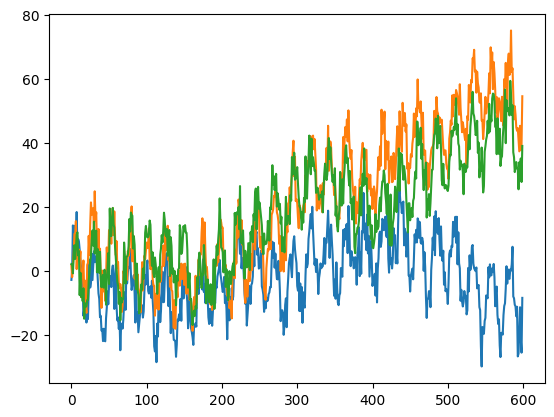

In [45]:
plt.plot(data.T)
np.set_printoptions(False)

In [46]:
### SLIDING WINDOW PARAMETER ###

window_len = 24*5

In [47]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,10))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len//3, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2.5)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation3.gif')
plt.close(fig)
print('DONE')

100%|██████████| 601/601 [01:06<00:00,  9.04it/s] 


CREATING GIF...
DONE


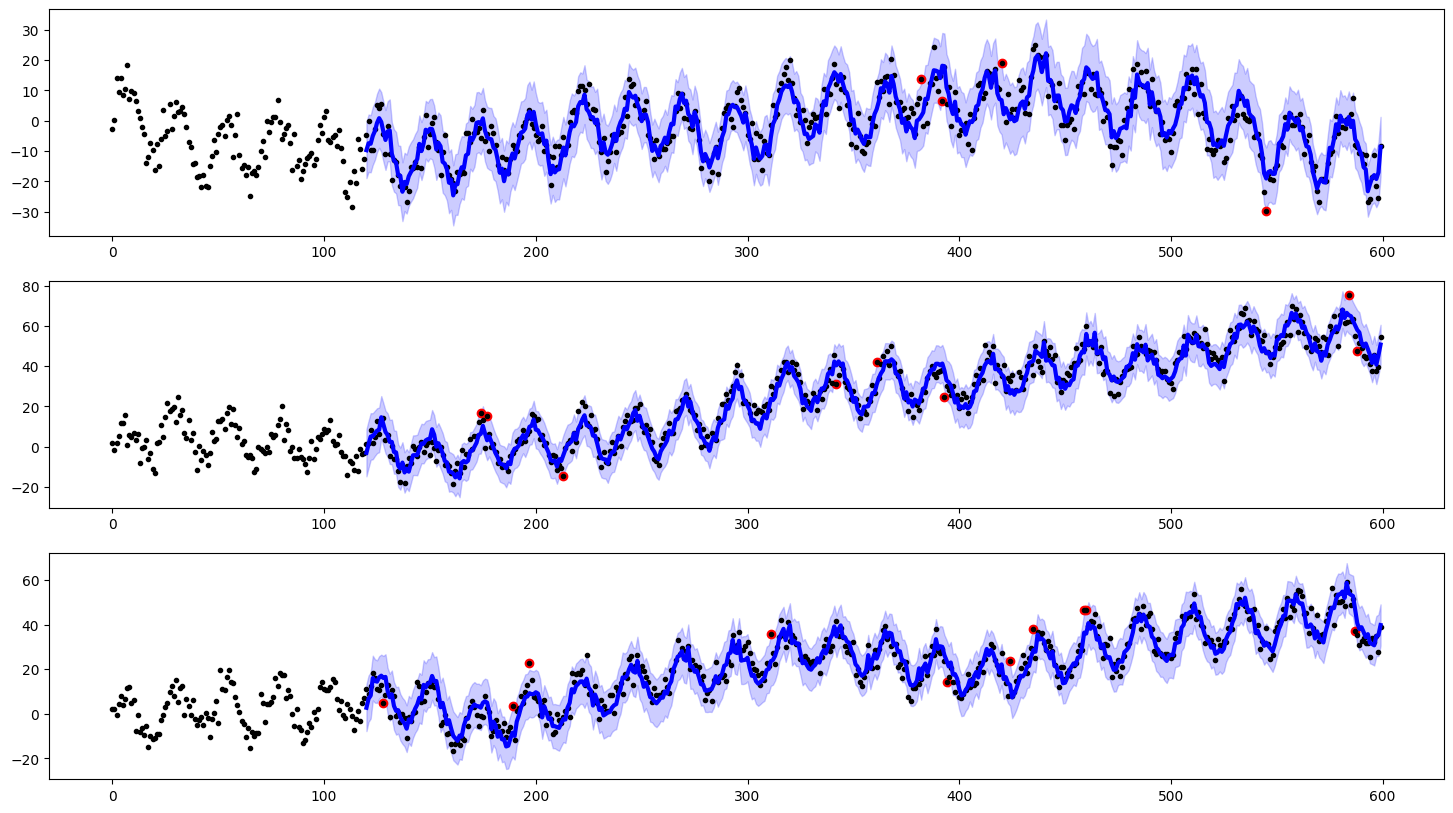

In [48]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

The smoothing mechanism and the computation of the residuals’ confidence bands work as before.

From the simulations, we can see that our approaches are able to detect peaks that don’t respect the seasonal patterns. We can also point out the pieces where our sensors deviate from the hypothetical pattern present in the past observations. In this last case, we also try to provide a reconstruction of the theoretical signal.

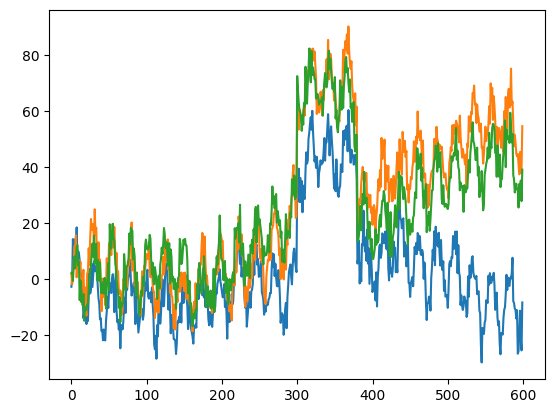

In [49]:
### GENERATE DATA ###

data[:,300:380] = data[:,300:380] + 40

plt.plot(data.T)
np.set_printoptions(False)

In [50]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

fig = plt.figure(figsize=(18,9))
camera = Camera(fig)

axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
recovered = np.copy(data)

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len, window_type='ones')
        smoother.smooth(series['recovered'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=4)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            ano_series = np.where(is_anomaly)[0]
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            recovered[ano_series,i] = smoother.smooth_data[ano_series,[-1]]
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    series['recovered'] = np.hstack([series['recovered'], recovered[:,[i]]])
    

print('CREATING GIF...')  # it may take a few seconds
camera._photos = [camera._photos[-1]] + camera._photos
animation = camera.animate()
animation.save('animation4.gif')
plt.close(fig)
print('DONE')

100%|██████████| 601/601 [01:23<00:00,  7.22it/s] 


CREATING GIF...
DONE


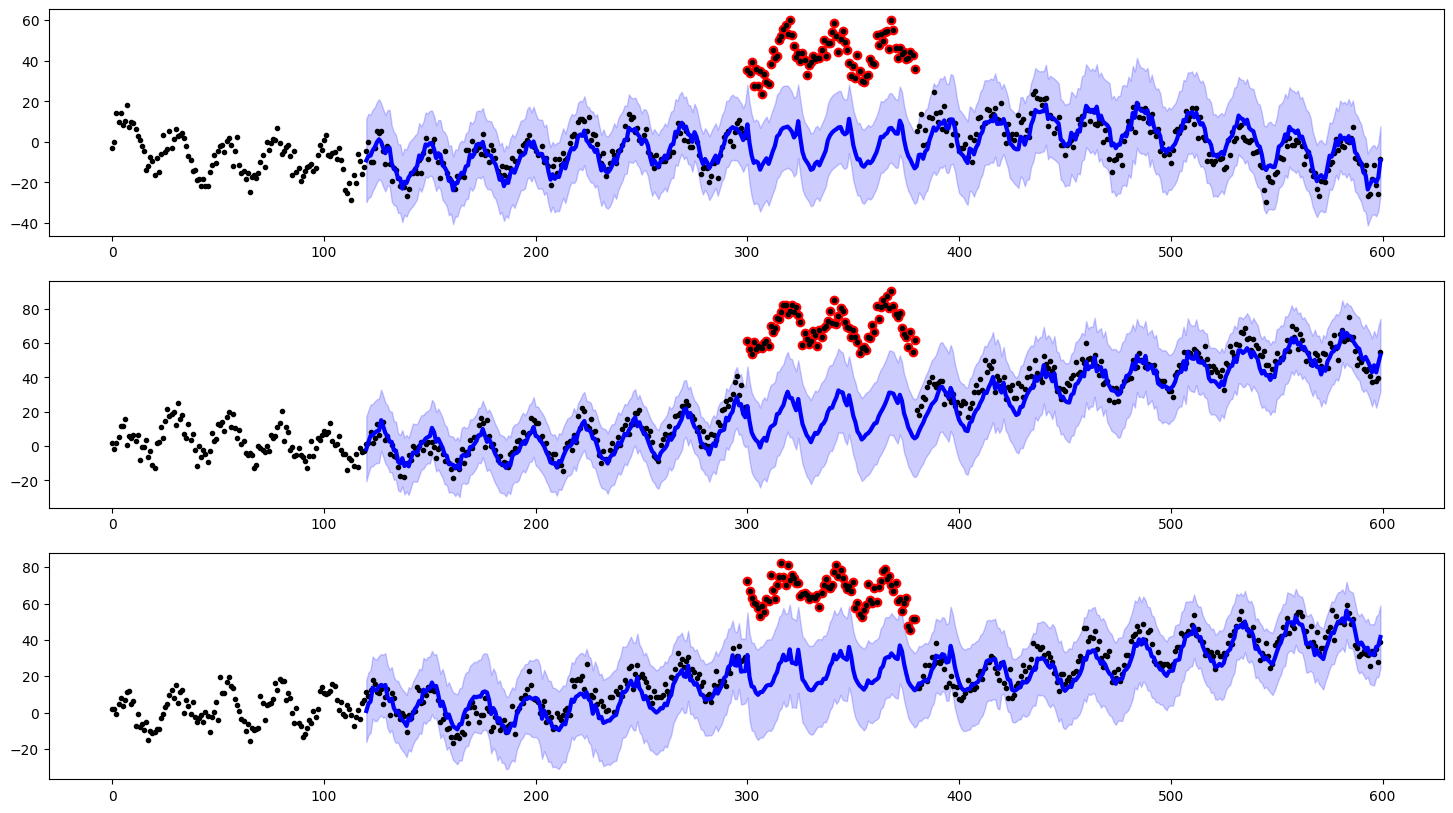

In [51]:
### PLOT FINAL RESULT ###

fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)

## Extreme Event Time Series Preprocessing 

Preprocessing is an essential step in every pipeline involving the development of a forecasting or analytic tool. In case we are dealing with time series, the most important things to take into account are resampling and filling possible missing values. 

While resampling is a semi automatic procedure that, in the best cases, can be directly derived from studying the frequency of the series, missing data imputation is more critical. The choice of a particularly important with time series, where we have to take care of possible temporal dependency when replacing the 'NaNs' to leverage the best possible outcomes. These tricks are useful not only in the presence of missing values but also in the presence of extreme events in the data stream that we want to mitigate. 

In [1]:
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

from sklearn.metrics import mean_squared_error

In [2]:
### SIMULATE DATA ###

np.random.seed(555)

n_series, timesteps = 100, 600

original = sim_randomwalk(n_series=n_series, timesteps=timesteps, 
                          process_noise=1, measure_noise=0)
seasons = sim_seasonal_data(n_series=n_series, timesteps=timesteps, 
                            freq=24, measure_noise=4, level=0, amp=10)
original = original + seasons

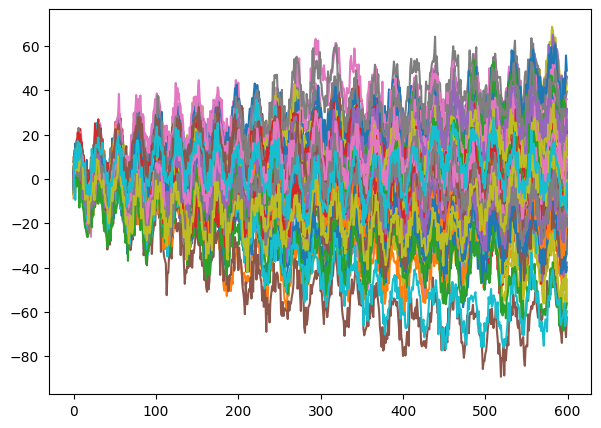

In [3]:
plt.figure(figsize=(7,5))
plt.plot(original.T)
np.set_printoptions(False)

To have an empirical demonstration of what we are trying to achieve we generate some simulated data. More specifically, we create some artificial time series with seasonal and trend behaviors.

They present a trend pattern with a seasonality of 24 periods. Given these data, we introduce some lacks replacing intervals of observation with missing values. We are forcing the introduction of missing data intervals but this can be a common and unexpected behavior that may present in our analysis. On the opposite, another inconvenience appears when we observe a period characterized by extreme turbulence or unusual breaks. A safe bet would be to mask these values and properly fill them.

Our workflow is very simple. We take the time series and generate some random missing intervals on them. We aim to try to fill them in the best way possible. This is a tricky task because our time series have a trend and seasonality that we want to respect. We need to adopt some techniques that can reproduce the right pattern in the best way possible. In the end, we test the goodness of our work by computing an error score to compare the goodness of our filling with the true reality that we have previously censored.

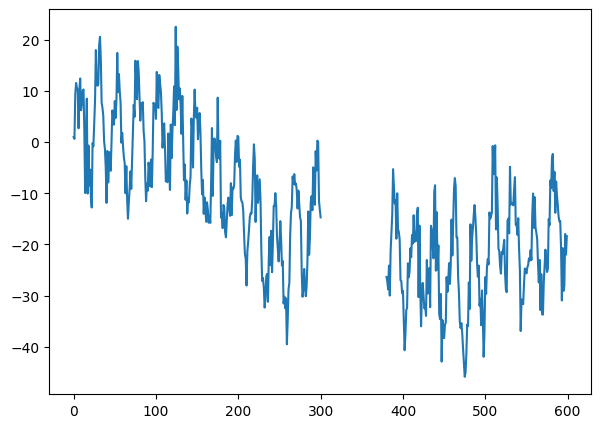

In [4]:
### MASK DATA ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original[[0]])
restored[:,mask] = np.nan

plt.figure(figsize=(7,5))
plt.plot(restored.T)
np.set_printoptions(False)

### Algortihms and Experiment

The simplest methods, which include every possible interpolation technique, don’t sound good for this kind of data. They can detect the underlying trend of the processes but are not able to correctly reproduce the seasonality level. For this reason, we try to fill our series with two very effective algorithms which are very common in the domain of time-series analytics. We are referring to the Kalman Filter and the Seasonal Trend Decomposition.

In [5]:
### OPERATE SMOOTHING ###

smoother = KalmanSmoother(component='level_season', n_seasons=24,
                          component_noise={'level':0.01,'season':0.01})
smoother.smooth(restored)

<tsmoothie.smoother.KalmanSmoother>

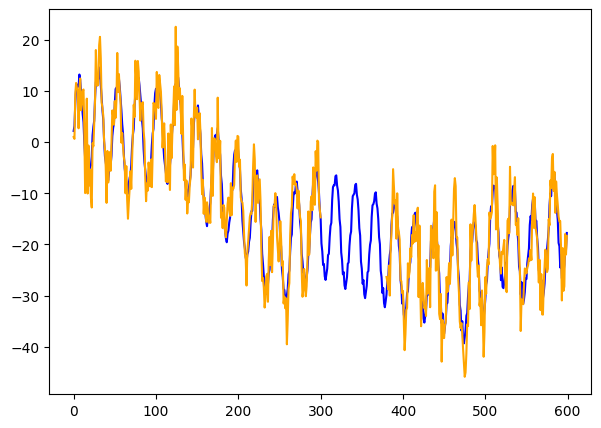

In [6]:
### COMPARE RECONSTRUCTION WITH ORIGINAL ###

plt.figure(figsize=(7,5))
plt.plot(smoother.smooth_data.T, c='blue')
plt.plot(smoother.data.T, c='orange')
np.set_printoptions(False)

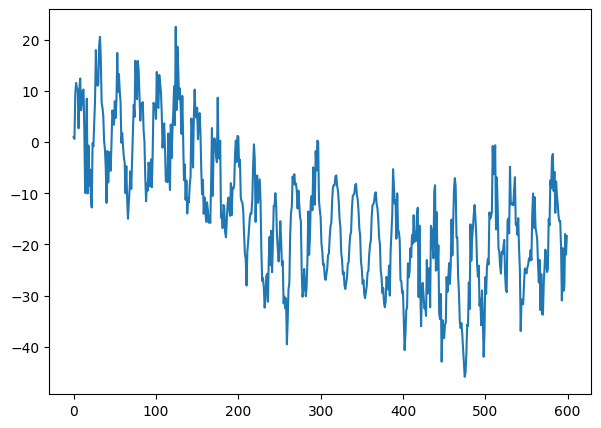

In [7]:
### RECOVERY DATA ###

restored[:,mask] = smoother.smooth_data[:,mask]

plt.figure(figsize=(7,5))
plt.plot(restored.T)
np.set_printoptions(False)

In our particular case, we use the Kalman Filter and a state-space representation to build an unobserved component model. All we need to do is make some simple assumptions about the underlying process of our data. A trend component and a simple seasonality of 24 periods are good for us. At this point, we are ready to ‘smooth’. The great practical advantage of a Kalman Smoother is that it can perform operations not taking care of missing values. This characteristic is optimal for us to fill our missing intervals of NaNs respecting the features of our data. 



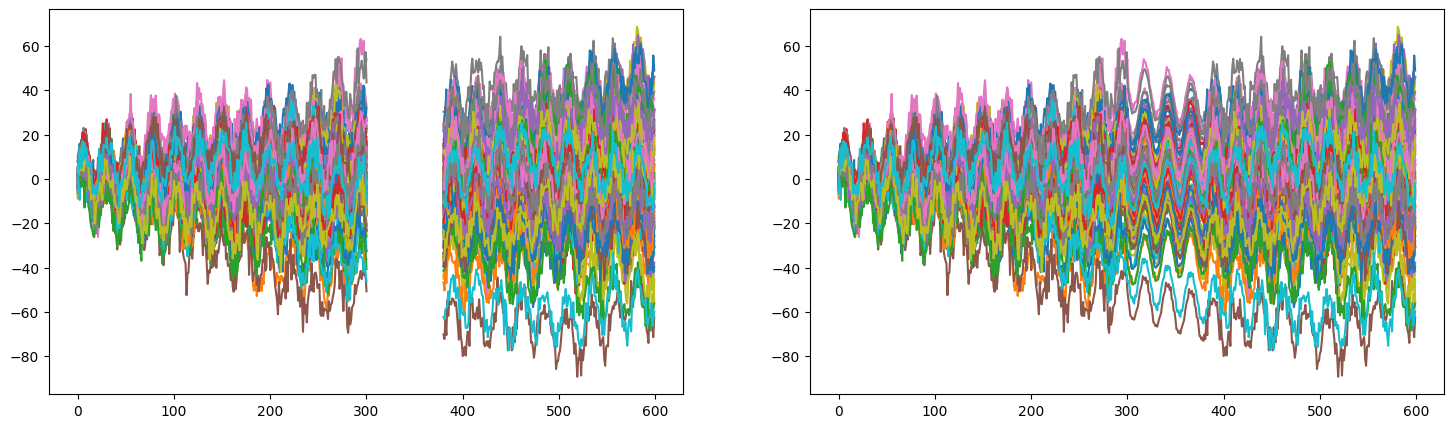

In [8]:
### SIMULATION WITH N SERIES, SINGLE INTERVAL AND KALMAN ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original)
restored[:,mask] = np.nan

plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(restored.T)

smoother = KalmanSmoother(component='level_season', n_seasons=24,
                          component_noise={'level':0.01,'season':0.01})
smoother.smooth(restored)

restored[:,mask] = smoother.smooth_data[:,mask]

plt.subplot(122)
plt.plot(restored.T)
np.set_printoptions(False)

In [9]:
### SIMULATION WITH N SERIES, MULTIPLE INTERVAL LENGTHS AND KALMAN ###

errors1 = {}

for i in tqdm(range(200, 500, 100)):
    
    mask = np.logical_and(np.arange(timesteps)>100, np.arange(timesteps)<i)

    restored = np.copy(original)
    restored[:,mask] = np.nan
    
    smoother = KalmanSmoother(component='level_season', n_seasons=24,
                              component_noise={'level':0.01,'season':0.01})
    smoother.smooth(restored)

    restored[:,mask] = smoother.smooth_data[:,mask]
    errors1[i-100] = mean_squared_error(original.T, restored.T)

100%|██████████| 3/3 [02:48<00:00, 56.03s/it] 


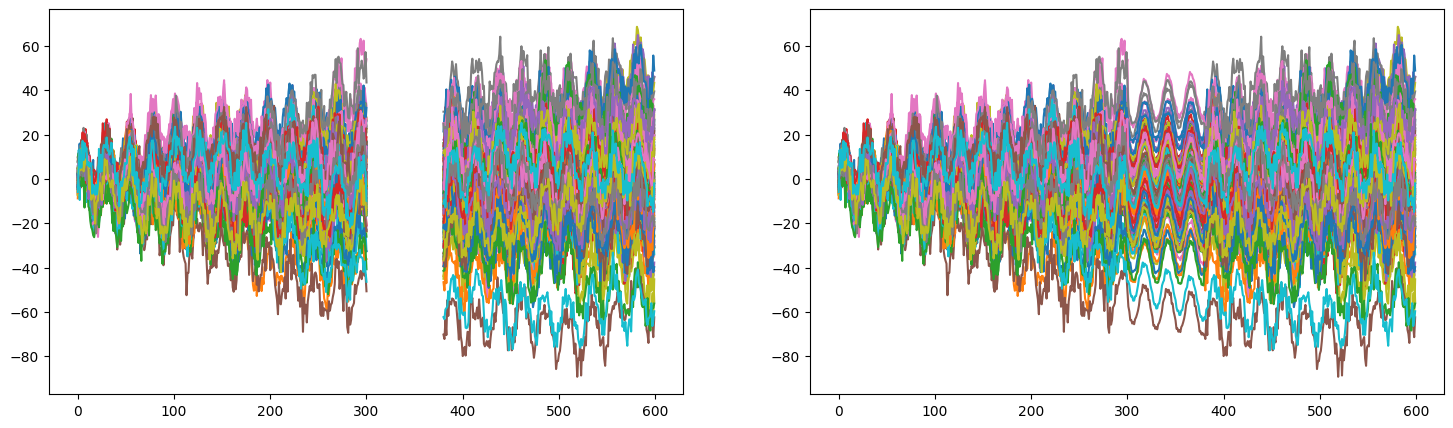

In [10]:
### SIMULATION WITH N SERIES, SINGLE INTERVAL AND SEASONAL DECOMPOSITION ###

mask = np.logical_and(np.arange(timesteps)>300, np.arange(timesteps)<380)

restored = np.copy(original)
restored[:,mask] = np.nan

plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(restored.T)

not_nan = np.logical_not(np.isnan(restored))
indices = np.arange(restored.shape[1])
for i in range(n_series):
    interpolation = interp1d(indices[not_nan[i]], restored[i,not_nan[i]])
    restored[i] = interpolation(indices)

smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                             window_len=200, window_type='ones')
smoother.smooth(restored)

restored[:,mask] = smoother.smooth_data[:,mask]

plt.subplot(122)
plt.plot(restored.T)
np.set_printoptions(False)

In [11]:
### SIMULATION WITH N SERIES, MULTIPLE INTERVAL LENGTHS AND SEASONAL DECOMPOSITION ###

errors2 = {}

for i in tqdm(range(300, 600, 100)):
    
    mask = np.logical_and(np.arange(timesteps)>200, np.arange(timesteps)<i)

    restored = np.copy(original)
    restored[:,mask] = np.nan
    
    not_nan = np.logical_not(np.isnan(restored))
    indices = np.arange(restored.shape[1])
    for s in range(n_series):
        interpolation = interp1d(indices[not_nan[s]], restored[s,not_nan[s]])
        restored[s] = interpolation(indices)

    smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                 window_len=(i-100), window_type='ones')
    smoother.smooth(restored)

    restored[:,mask] = smoother.smooth_data[:,mask]
    errors2[i-100] = mean_squared_error(original.T, restored.T)

100%|██████████| 3/3 [00:00<00:00, 13.57it/s]


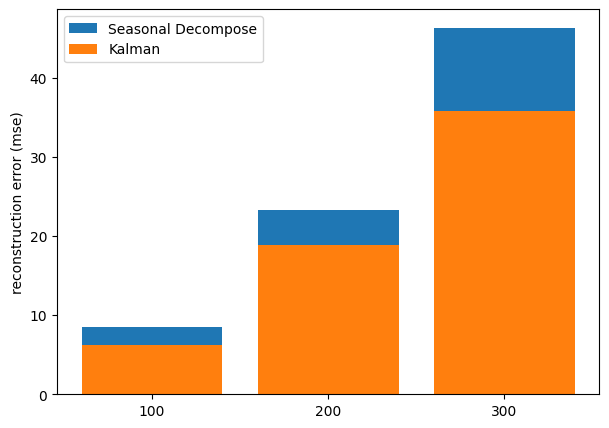

In [12]:
### COMPARE RECONSTRUCTION ERRORS ###

plt.figure(figsize=(7,5))
plt.bar(range(3), errors2.values(), label='Seasonal Decompose')
plt.bar(range(3), errors1.values(), label='Kalman')
plt.xticks(range(len(errors1.keys())), errors1.keys())
plt.ylabel('reconstruction error (mse)'); plt.legend()
np.set_printoptions(False)

## Extreme Event Forecasting

In [1]:
import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

2023-03-20 22:36:28.370589: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### READ DATASET ###

url='https://raw.githubusercontent.com/cerlymarco/MEDIUM_NoteBook/master/Extreme_Event_Forecasting/avocado.csv'
df = pd.read_csv(url, index_col=0, parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df['test_flag'] = (df['year']==2018)

print(df.shape)
df.head()

(18249, 13)


AveragePrice  Total Volume     4046      4225     4770  \
Date                                                                 
2015-01-04          1.75      27365.89  9307.34   3844.81   615.28   
2015-01-04          1.49      17723.17  1189.35  15628.27     0.00   
2015-01-04          1.68       2896.72   161.68    206.96     0.00   
2015-01-04          1.52      54956.80  3013.04  35456.88  1561.70   
2015-01-04          1.64       1505.12     1.27   1129.50     0.00   

            Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
Date                                                                        
2015-01-04    13598.46    13061.10      537.36          0.0       organic   
2015-01-04      905.55      905.55        0.00          0.0       organic   
2015-01-04     2528.08     2528.08        0.00          0.0       organic   
2015-01-04    14925.18    11264.80     3660.38          0.0  conventional   
2015-01-04      374.35      186.67      187.68          0.0       organic   

            year              region  test_flag  
Date                                             
2015-01-04  2015           Southeast      False  
2015-01-04  2015             Chicago      False  
2015-01-04  2015  HarrisburgScranton      False  
2015-01-04  2015          Pittsburgh      False  
2015-01-04  2015               Boise      False

In [3]:
### PLOT SERIES FOR SINGLE MARKET OF SELECTED AVOCADO TYPE ###

def plot_seris(county, typ):
    
    plt.figure(figsize=(9,6))
    
    df[(df['type']==typ)&(df['region']==county)&(df['test_flag']==False)]['AveragePrice'].plot()
    df[(df['type']==typ)&(df['region']==county)&(df['test_flag']==True)]['AveragePrice'].plot()
    
    plt.title('AveragePrice'+' '+typ.upper()+' '+county)
    plt.show()

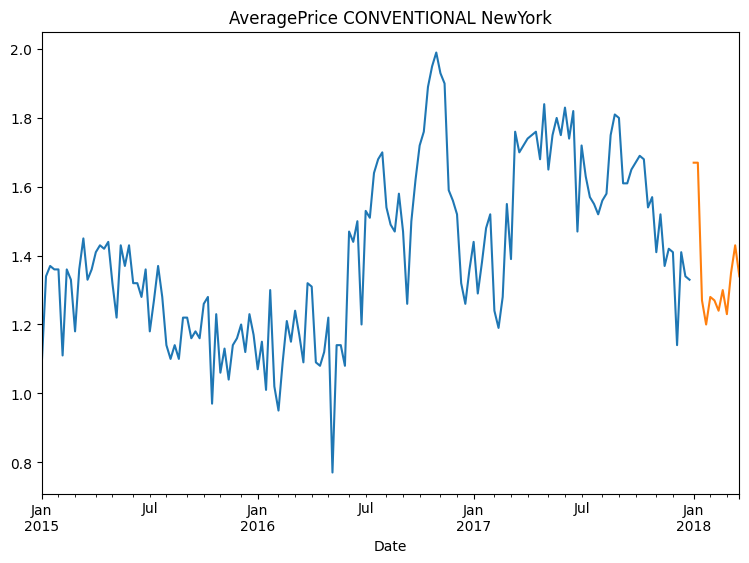

In [4]:
reg_train = plot_seris('NewYork','conventional')

In [5]:
### CREATE GENERATOR FOR LSTM WINDOWS AND LABELS ###

sequence_length = 4


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [6]:
### CREATE TRAIN/TEST PRICE DATA ###

col = ['AveragePrice','Total Volume','4046','4225','4770','Total Bags','Small Bags','Large Bags','XLarge Bags']

X_train, X_test = [], []
y_train, y_test = [], []

for (county,typ,is_test), _df in df.groupby(["region", "type", "test_flag"]):
    
    for seq in gen_sequence(_df, sequence_length, col):            
        
        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)

        if is_test:
            X_test.append(seq)
        else:
            X_train.append(seq)
                
    for seq in gen_labels(_df, sequence_length, ['AveragePrice']):
        
        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)

        if is_test:
            y_test.append(seq)
        else:
            y_train.append(seq)      
        
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33042, 4, 9) (33042, 1)
(1728, 4, 9) (1728, 1)


In [8]:
X_train[0]

array([[1.220000e+00, 4.087328e+04, 2.819500e+03, 2.828742e+04,
        4.990000e+01, 9.716460e+03, 9.186930e+03, 5.295300e+02,
        0.000000e+00],
       [1.240000e+00, 4.119508e+04, 1.002850e+03, 3.164034e+04,
        1.271200e+02, 8.424770e+03, 8.036040e+03, 3.887300e+02,
        0.000000e+00],
       [1.170000e+00, 4.451128e+04, 9.141400e+02, 3.154032e+04,
        1.357700e+02, 1.192105e+04, 1.165109e+04, 2.699600e+02,
        0.000000e+00],
       [1.060000e+00, 4.514750e+04, 9.413800e+02, 3.319616e+04,
        1.641400e+02, 1.084582e+04, 1.010335e+04, 7.424700e+02,
        0.000000e+00]])

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

### Forecast + AutoEncoder

In [10]:
set_seed(33)

### DEFINE LSTM AUTOENCODER ###

inputs_ae = Input(shape=(X_train.shape[1:]))
encoded_ae = LSTM(128, return_sequences=True, dropout=0.5)(inputs_ae, training=True)
decoded_ae = LSTM(32, return_sequences=True, dropout=0.5)(encoded_ae, training=True)
out_ae = TimeDistributed(Dense(1))(decoded_ae)

sequence_autoencoder = Model(inputs_ae, out_ae)
sequence_autoencoder.compile(optimizer='adam', loss='mse')

### TRAIN AUTOENCODER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
sequence_autoencoder.fit(X_train, X_train, validation_data=(X_train, X_train),
                         batch_size=128, epochs=100, verbose=1, callbacks=[es])

2023-03-20 22:44:55.437984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
259/259 [==============================] - 65s 156ms/step - loss: 0.4932 - val_loss: 0.3956
Epoch 2/100
259/259 [==============================] - 36s 141ms/step - loss: 0.3844 - val_loss: 0.3850
Epoch 3/100
259/259 [==============================] - 35s 136ms/step - loss: 0.3744 - val_loss: 0.3786
Epoch 4/100
259/259 [==============================] - 36s 139ms/step - loss: 0.3724 - val_loss: 0.3691
Epoch 5/100
259/259 [==============================] - 48s 186ms/step - loss: 0.3684 - val_loss: 0.3698
Epoch 6/100
259/259 [==============================] - 57s 219ms/step - loss: 0.3690 - val_loss: 0.3677
Epoch 7/100
259/259 [==============================] - 44s 170ms/step - loss: 0.3658 - val_loss: 0.3646
Epoch 8/100
259/259 [==============================] - 41s 160ms/step - loss: 0.3630 - val_loss: 0.3640
Epoch 9/100
259/259 [==============================] - 80s 308ms/step - loss: 0.3646 - val_loss: 0.3637
Epoch 10/100
259/259 [==============================] - 87s 336m

In [11]:
### ENCODE PRICE AND CONCATENATE REGRESSORS ###

encoder = Model(inputs_ae, encoded_ae)
X_train_ = np.concatenate([X_train, encoder.predict(X_train)], axis=-1)
X_test_ = np.concatenate([X_test, encoder.predict(X_test)], axis=-1)

X_train_.shape, X_test_.shape

54/54 [==============================] - 1s 14ms/step


((33042, 4, 137), (1728, 4, 137))

In [12]:
set_seed(33)

### DEFINE FORECASTER ###

inputs = Input(shape=(X_train_.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train_, y_train, validation_data=(X_train_, y_train), 
          epochs=100, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/100
259/259 [==============================] - 68s 164ms/step - loss: 0.1199 - val_loss: 0.0495
Epoch 2/100
259/259 [==============================] - 36s 138ms/step - loss: 0.0478 - val_loss: 0.0461
Epoch 3/100
259/259 [==============================] - 40s 155ms/step - loss: 0.0446 - val_loss: 0.0430
Epoch 4/100
259/259 [==============================] - 37s 144ms/step - loss: 0.0429 - val_loss: 0.0421
Epoch 5/100
259/259 [==============================] - 33s 127ms/step - loss: 0.0420 - val_loss: 0.0412
Epoch 6/100
259/259 [==============================] - 34s 131ms/step - loss: 0.0413 - val_loss: 0.0399
Epoch 7/100
259/259 [==============================] - 30s 116ms/step - loss: 0.0396 - val_loss: 0.0399
Epoch 8/100
259/259 [==============================] - 30s 114ms/step - loss: 0.0396 - val_loss: 0.0397
Epoch 9/100
259/259 [==============================] - 31s 119ms/step - loss: 0.0389 - val_loss: 0.0384
Epoch 10/100
259/259 [==============================] - 34s 129m

In [13]:
### COMPUTE STOCHASTIC DROPOUT ###

scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test_).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

54/54 [==============================] - 7s 23ms/step


  1%|          | 1/100 [00:07<13:00,  7.88s/it]

54/54 [==============================] - 1s 24ms/step


  2%|▏         | 2/100 [00:09<06:52,  4.21s/it]

54/54 [==============================] - 1s 24ms/step


  3%|▎         | 3/100 [00:11<04:58,  3.08s/it]

54/54 [==============================] - 1s 23ms/step


  4%|▍         | 4/100 [00:12<04:02,  2.52s/it]

54/54 [==============================] - 1s 19ms/step


  5%|▌         | 5/100 [00:14<03:25,  2.17s/it]

54/54 [==============================] - 1s 18ms/step


  6%|▌         | 6/100 [00:15<02:54,  1.86s/it]

54/54 [==============================] - 1s 23ms/step


  7%|▋         | 7/100 [00:17<02:45,  1.78s/it]

54/54 [==============================] - 1s 22ms/step


  8%|▊         | 8/100 [00:18<02:36,  1.70s/it]

54/54 [==============================] - 1s 20ms/step


  9%|▉         | 9/100 [00:20<02:25,  1.60s/it]

54/54 [==============================] - 1s 22ms/step


 10%|█         | 10/100 [00:21<02:19,  1.55s/it]

54/54 [==============================] - 1s 27ms/step


 11%|█         | 11/100 [00:23<02:22,  1.60s/it]

54/54 [==============================] - 1s 22ms/step


 12%|█▏        | 12/100 [00:24<02:20,  1.60s/it]

54/54 [==============================] - 1s 19ms/step


 13%|█▎        | 13/100 [00:26<02:13,  1.53s/it]

54/54 [==============================] - 1s 25ms/step


 14%|█▍        | 14/100 [00:28<02:26,  1.71s/it]

54/54 [==============================] - 2s 25ms/step


 15%|█▌        | 15/100 [00:31<03:10,  2.24s/it]

54/54 [==============================] - 1s 19ms/step


 16%|█▌        | 16/100 [00:33<02:45,  1.97s/it]

54/54 [==============================] - 1s 18ms/step


 17%|█▋        | 17/100 [00:34<02:26,  1.76s/it]

54/54 [==============================] - 1s 26ms/step


 18%|█▊        | 18/100 [00:36<02:24,  1.76s/it]

54/54 [==============================] - 2s 28ms/step


 19%|█▉        | 19/100 [00:39<02:51,  2.12s/it]

54/54 [==============================] - 1s 17ms/step


 20%|██        | 20/100 [00:40<02:27,  1.84s/it]

54/54 [==============================] - 1s 20ms/step


 21%|██        | 21/100 [00:42<02:17,  1.74s/it]

54/54 [==============================] - 1s 19ms/step


 22%|██▏       | 22/100 [00:43<02:07,  1.63s/it]

54/54 [==============================] - 1s 19ms/step


 23%|██▎       | 23/100 [00:44<01:57,  1.53s/it]

54/54 [==============================] - 1s 19ms/step


 24%|██▍       | 24/100 [00:46<01:52,  1.47s/it]

54/54 [==============================] - 1s 19ms/step


 25%|██▌       | 25/100 [00:47<01:51,  1.48s/it]

54/54 [==============================] - 2s 26ms/step


 26%|██▌       | 26/100 [00:49<01:58,  1.60s/it]

54/54 [==============================] - 1s 26ms/step


 27%|██▋       | 27/100 [00:52<02:24,  1.98s/it]

54/54 [==============================] - 2s 30ms/step


 28%|██▊       | 28/100 [00:54<02:29,  2.08s/it]

54/54 [==============================] - 2s 27ms/step


 29%|██▉       | 29/100 [00:57<02:50,  2.40s/it]

54/54 [==============================] - 1s 26ms/step


 30%|███       | 30/100 [00:59<02:40,  2.29s/it]

54/54 [==============================] - 3s 44ms/step


 31%|███       | 31/100 [01:03<02:59,  2.60s/it]

54/54 [==============================] - 1s 20ms/step


 32%|███▏      | 32/100 [01:04<02:36,  2.31s/it]

54/54 [==============================] - 1s 22ms/step


 33%|███▎      | 33/100 [01:06<02:23,  2.14s/it]

54/54 [==============================] - 1s 21ms/step


 34%|███▍      | 34/100 [01:08<02:11,  1.99s/it]

54/54 [==============================] - 1s 20ms/step


 35%|███▌      | 35/100 [01:09<02:02,  1.89s/it]

54/54 [==============================] - 2s 32ms/step


 36%|███▌      | 36/100 [01:12<02:11,  2.06s/it]

54/54 [==============================] - 2s 27ms/step


 37%|███▋      | 37/100 [01:14<02:12,  2.10s/it]

54/54 [==============================] - 1s 24ms/step


 38%|███▊      | 38/100 [01:16<02:04,  2.00s/it]

54/54 [==============================] - 1s 18ms/step


 39%|███▉      | 39/100 [01:17<01:48,  1.78s/it]

54/54 [==============================] - 1s 20ms/step


 40%|████      | 40/100 [01:18<01:41,  1.69s/it]

54/54 [==============================] - 1s 24ms/step


 41%|████      | 41/100 [01:20<01:40,  1.70s/it]

54/54 [==============================] - 2s 29ms/step


 42%|████▏     | 42/100 [01:22<01:49,  1.89s/it]

54/54 [==============================] - 3s 43ms/step


 43%|████▎     | 43/100 [01:26<02:22,  2.49s/it]

54/54 [==============================] - 2s 29ms/step


 44%|████▍     | 44/100 [01:29<02:30,  2.68s/it]

54/54 [==============================] - 1s 18ms/step


 45%|████▌     | 45/100 [01:31<02:14,  2.45s/it]

54/54 [==============================] - 2s 39ms/step


 46%|████▌     | 46/100 [01:34<02:18,  2.57s/it]

54/54 [==============================] - 1s 21ms/step


 47%|████▋     | 47/100 [01:36<02:02,  2.32s/it]

54/54 [==============================] - 2s 29ms/step


 48%|████▊     | 48/100 [01:38<01:59,  2.30s/it]

54/54 [==============================] - 2s 38ms/step


 49%|████▉     | 49/100 [01:41<02:08,  2.51s/it]

54/54 [==============================] - 2s 42ms/step


 50%|█████     | 50/100 [01:44<02:13,  2.66s/it]

54/54 [==============================] - 1s 20ms/step


 51%|█████     | 51/100 [01:46<01:53,  2.32s/it]

54/54 [==============================] - 1s 21ms/step


 52%|█████▏    | 52/100 [01:47<01:41,  2.12s/it]

54/54 [==============================] - 2s 27ms/step


 53%|█████▎    | 53/100 [01:50<01:39,  2.12s/it]

54/54 [==============================] - 2s 29ms/step


 54%|█████▍    | 54/100 [01:53<01:49,  2.38s/it]

54/54 [==============================] - 1s 22ms/step


 55%|█████▌    | 55/100 [01:54<01:38,  2.20s/it]

54/54 [==============================] - 1s 19ms/step


 56%|█████▌    | 56/100 [01:56<01:27,  1.99s/it]

54/54 [==============================] - 1s 22ms/step


 57%|█████▋    | 57/100 [01:57<01:21,  1.89s/it]

54/54 [==============================] - 1s 20ms/step


 58%|█████▊    | 58/100 [01:59<01:15,  1.80s/it]

54/54 [==============================] - 1s 22ms/step


 59%|█████▉    | 59/100 [02:01<01:14,  1.83s/it]

54/54 [==============================] - 1s 23ms/step


 60%|██████    | 60/100 [02:03<01:12,  1.80s/it]

54/54 [==============================] - 1s 21ms/step


 61%|██████    | 61/100 [02:04<01:08,  1.76s/it]

54/54 [==============================] - 1s 25ms/step


 62%|██████▏   | 62/100 [02:06<01:08,  1.81s/it]

54/54 [==============================] - 2s 34ms/step


 63%|██████▎   | 63/100 [02:09<01:15,  2.05s/it]

54/54 [==============================] - 1s 20ms/step


 64%|██████▍   | 64/100 [02:11<01:10,  1.94s/it]

54/54 [==============================] - 1s 20ms/step


 65%|██████▌   | 65/100 [02:12<01:06,  1.90s/it]

54/54 [==============================] - 1s 21ms/step


 66%|██████▌   | 66/100 [02:15<01:14,  2.19s/it]

54/54 [==============================] - 1s 20ms/step


 67%|██████▋   | 67/100 [02:18<01:18,  2.37s/it]

54/54 [==============================] - 1s 19ms/step


 68%|██████▊   | 68/100 [02:20<01:08,  2.15s/it]

54/54 [==============================] - 2s 32ms/step


 69%|██████▉   | 69/100 [02:22<01:08,  2.21s/it]

54/54 [==============================] - 1s 22ms/step


 70%|███████   | 70/100 [02:25<01:11,  2.39s/it]

54/54 [==============================] - 2s 33ms/step


 71%|███████   | 71/100 [02:28<01:12,  2.51s/it]

54/54 [==============================] - 2s 25ms/step


 72%|███████▏  | 72/100 [02:30<01:07,  2.42s/it]

54/54 [==============================] - 1s 25ms/step


 73%|███████▎  | 73/100 [02:32<00:59,  2.22s/it]

54/54 [==============================] - 2s 28ms/step


 74%|███████▍  | 74/100 [02:34<00:57,  2.21s/it]

54/54 [==============================] - 2s 35ms/step


 75%|███████▌  | 75/100 [02:36<00:58,  2.34s/it]

54/54 [==============================] - 2s 29ms/step


 76%|███████▌  | 76/100 [02:39<00:56,  2.37s/it]

54/54 [==============================] - 2s 25ms/step


 77%|███████▋  | 77/100 [02:42<00:59,  2.58s/it]

54/54 [==============================] - 1s 21ms/step


 78%|███████▊  | 78/100 [02:44<00:50,  2.30s/it]

54/54 [==============================] - 2s 26ms/step


 79%|███████▉  | 79/100 [02:46<00:52,  2.49s/it]

54/54 [==============================] - 2s 27ms/step


 80%|████████  | 80/100 [02:48<00:46,  2.33s/it]

54/54 [==============================] - 1s 20ms/step


 81%|████████  | 81/100 [02:50<00:40,  2.14s/it]

54/54 [==============================] - 1s 24ms/step


 82%|████████▏ | 82/100 [02:52<00:36,  2.03s/it]

54/54 [==============================] - 1s 20ms/step


 83%|████████▎ | 83/100 [02:54<00:32,  1.92s/it]

54/54 [==============================] - 2s 27ms/step


 84%|████████▍ | 84/100 [02:56<00:31,  1.98s/it]

54/54 [==============================] - 1s 18ms/step


 85%|████████▌ | 85/100 [02:57<00:27,  1.86s/it]

54/54 [==============================] - 1s 20ms/step


 86%|████████▌ | 86/100 [02:59<00:24,  1.77s/it]

54/54 [==============================] - 1s 20ms/step


 87%|████████▋ | 87/100 [03:01<00:22,  1.76s/it]

54/54 [==============================] - 2s 31ms/step


 88%|████████▊ | 88/100 [03:03<00:24,  2.01s/it]

54/54 [==============================] - 2s 27ms/step


 89%|████████▉ | 89/100 [03:05<00:23,  2.10s/it]

54/54 [==============================] - 2s 34ms/step


 90%|█████████ | 90/100 [03:08<00:22,  2.20s/it]

54/54 [==============================] - 2s 37ms/step


 91%|█████████ | 91/100 [03:10<00:20,  2.31s/it]

54/54 [==============================] - 2s 29ms/step


 92%|█████████▏| 92/100 [03:13<00:18,  2.32s/it]

54/54 [==============================] - 2s 36ms/step


 93%|█████████▎| 93/100 [03:16<00:17,  2.52s/it]

54/54 [==============================] - 2s 27ms/step


 94%|█████████▍| 94/100 [03:19<00:17,  2.84s/it]

54/54 [==============================] - 1s 25ms/step


 95%|█████████▌| 95/100 [03:22<00:14,  2.85s/it]

54/54 [==============================] - 1s 22ms/step


 96%|█████████▌| 96/100 [03:24<00:09,  2.47s/it]

54/54 [==============================] - 1s 24ms/step


 97%|█████████▋| 97/100 [03:26<00:06,  2.30s/it]

54/54 [==============================] - 1s 23ms/step


 98%|█████████▊| 98/100 [03:28<00:04,  2.16s/it]

54/54 [==============================] - 2s 27ms/step


 99%|█████████▉| 99/100 [03:30<00:02,  2.12s/it]

54/54 [==============================] - 2s 33ms/step


100%|██████████| 100/100 [03:33<00:00,  2.13s/it]

0.12285364415304803 0.0013024834338051267


In [14]:
results = {'LSTM':None, 'AE+LSTM':None}
results['AE+LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

### Simple Forecaster

In [15]:
set_seed(33)

### DEFINE FORECASTER ###

inputs = Input(shape=(X_train.shape[1:]))
lstm = LSTM(128, return_sequences=True, dropout=0.5)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.5)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)

model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam')

### FIT FORECASTER ###
es = EarlyStopping(patience=6, verbose=2, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_train, y_train), 
          epochs=100, batch_size=128, verbose=1, callbacks=[es])

Epoch 1/100
259/259 [==============================] - 56s 140ms/step - loss: 0.1776 - val_loss: 0.0575
Epoch 2/100
259/259 [==============================] - 45s 175ms/step - loss: 0.0567 - val_loss: 0.0559
Epoch 3/100
259/259 [==============================] - 27s 104ms/step - loss: 0.0531 - val_loss: 0.0518
Epoch 4/100
259/259 [==============================] - 30s 116ms/step - loss: 0.0505 - val_loss: 0.0500
Epoch 5/100
259/259 [==============================] - 27s 106ms/step - loss: 0.0491 - val_loss: 0.0481
Epoch 6/100
259/259 [==============================] - 27s 104ms/step - loss: 0.0489 - val_loss: 0.0476
Epoch 7/100
259/259 [==============================] - 31s 118ms/step - loss: 0.0480 - val_loss: 0.0471
Epoch 8/100
259/259 [==============================] - 29s 113ms/step - loss: 0.0469 - val_loss: 0.0461
Epoch 9/100
259/259 [==============================] - 41s 157ms/step - loss: 0.0460 - val_loss: 0.0461
Epoch 10/100
259/259 [==============================] - 31s 121m

In [16]:
### COMPUTE STOCHASTIC DROPOUT ###

scores = []
for i in tqdm.tqdm(range(0,100)):
    scores.append(mean_absolute_error(y_test, model.predict(X_test).ravel()))

print(np.mean(scores), np.std(scores))

  0%|          | 0/100 [00:00<?, ?it/s]

54/54 [==============================] - 5s 19ms/step


  1%|          | 1/100 [00:56<1:32:52, 56.29s/it]

54/54 [==============================] - 1s 21ms/step


  2%|▏         | 2/100 [00:58<39:39, 24.28s/it]  

54/54 [==============================] - 2s 29ms/step


  3%|▎         | 3/100 [01:01<23:28, 14.52s/it]

54/54 [==============================] - 1s 20ms/step


  4%|▍         | 4/100 [01:02<15:00,  9.38s/it]

54/54 [==============================] - 1s 21ms/step


  5%|▌         | 5/100 [01:04<10:27,  6.61s/it]

54/54 [==============================] - 1s 26ms/step


  6%|▌         | 6/100 [01:07<08:20,  5.32s/it]

54/54 [==============================] - 2s 31ms/step


  7%|▋         | 7/100 [01:10<07:03,  4.55s/it]

54/54 [==============================] - 1s 23ms/step


  8%|▊         | 8/100 [01:11<05:35,  3.65s/it]

54/54 [==============================] - 2s 37ms/step


  9%|▉         | 9/100 [01:14<05:04,  3.35s/it]

54/54 [==============================] - 1s 27ms/step


 10%|█         | 10/100 [01:16<04:21,  2.90s/it]

54/54 [==============================] - 2s 33ms/step


 11%|█         | 11/100 [01:19<04:24,  2.97s/it]

54/54 [==============================] - 1s 24ms/step


 12%|█▏        | 12/100 [01:21<03:44,  2.56s/it]

54/54 [==============================] - 1s 22ms/step


 13%|█▎        | 13/100 [01:22<03:17,  2.27s/it]

54/54 [==============================] - 1s 23ms/step


 14%|█▍        | 14/100 [01:24<03:01,  2.12s/it]

54/54 [==============================] - 1s 25ms/step


 15%|█▌        | 15/100 [01:26<02:52,  2.03s/it]

54/54 [==============================] - 1s 17ms/step


 16%|█▌        | 16/100 [01:27<02:34,  1.84s/it]

54/54 [==============================] - 1s 18ms/step


 17%|█▋        | 17/100 [01:29<02:21,  1.70s/it]

54/54 [==============================] - 1s 22ms/step


 18%|█▊        | 18/100 [01:30<02:18,  1.69s/it]

54/54 [==============================] - 1s 18ms/step


 19%|█▉        | 19/100 [01:32<02:09,  1.60s/it]

54/54 [==============================] - 1s 20ms/step


 20%|██        | 20/100 [01:33<02:03,  1.55s/it]

54/54 [==============================] - 1s 17ms/step


 21%|██        | 21/100 [01:34<01:54,  1.45s/it]

54/54 [==============================] - 2s 31ms/step


 22%|██▏       | 22/100 [01:36<02:08,  1.65s/it]

54/54 [==============================] - 1s 21ms/step


 23%|██▎       | 23/100 [01:38<02:07,  1.66s/it]

54/54 [==============================] - 1s 17ms/step


 24%|██▍       | 24/100 [01:39<01:55,  1.52s/it]

54/54 [==============================] - 1s 26ms/step


 25%|██▌       | 25/100 [01:42<02:21,  1.88s/it]

54/54 [==============================] - 2s 34ms/step


 26%|██▌       | 26/100 [01:44<02:31,  2.04s/it]

54/54 [==============================] - 1s 25ms/step


 27%|██▋       | 27/100 [01:46<02:21,  1.94s/it]

54/54 [==============================] - 1s 16ms/step


 28%|██▊       | 28/100 [01:47<02:02,  1.70s/it]

54/54 [==============================] - 1s 19ms/step


 29%|██▉       | 29/100 [01:49<01:53,  1.60s/it]

54/54 [==============================] - 1s 19ms/step


 30%|███       | 30/100 [01:50<01:49,  1.56s/it]

54/54 [==============================] - 1s 19ms/step


 31%|███       | 31/100 [01:52<01:46,  1.54s/it]

54/54 [==============================] - 1s 22ms/step


 32%|███▏      | 32/100 [01:53<01:42,  1.51s/it]

54/54 [==============================] - 1s 16ms/step


 33%|███▎      | 33/100 [01:54<01:32,  1.38s/it]

54/54 [==============================] - 1s 24ms/step


 34%|███▍      | 34/100 [01:56<01:38,  1.49s/it]

54/54 [==============================] - 1s 21ms/step


 35%|███▌      | 35/100 [01:58<01:43,  1.58s/it]

54/54 [==============================] - 1s 21ms/step


 36%|███▌      | 36/100 [01:59<01:39,  1.55s/it]

54/54 [==============================] - 1s 23ms/step


 37%|███▋      | 37/100 [02:01<01:37,  1.55s/it]

54/54 [==============================] - 1s 18ms/step


 38%|███▊      | 38/100 [02:02<01:31,  1.48s/it]

54/54 [==============================] - 1s 26ms/step


 39%|███▉      | 39/100 [02:04<01:34,  1.55s/it]

54/54 [==============================] - 1s 19ms/step


 40%|████      | 40/100 [02:05<01:29,  1.50s/it]

54/54 [==============================] - 1s 21ms/step


 41%|████      | 41/100 [02:07<01:27,  1.49s/it]

54/54 [==============================] - 1s 22ms/step


 42%|████▏     | 42/100 [02:08<01:25,  1.48s/it]

54/54 [==============================] - 1s 25ms/step


 43%|████▎     | 43/100 [02:10<01:28,  1.56s/it]

54/54 [==============================] - 1s 22ms/step


 44%|████▍     | 44/100 [02:11<01:27,  1.57s/it]

54/54 [==============================] - 1s 18ms/step


 45%|████▌     | 45/100 [02:13<01:21,  1.49s/it]

54/54 [==============================] - 1s 16ms/step


 46%|████▌     | 46/100 [02:14<01:14,  1.39s/it]

54/54 [==============================] - 1s 25ms/step


 47%|████▋     | 47/100 [02:17<01:34,  1.78s/it]

54/54 [==============================] - 1s 23ms/step


 48%|████▊     | 48/100 [02:18<01:27,  1.69s/it]

54/54 [==============================] - 1s 15ms/step


 49%|████▉     | 49/100 [02:19<01:16,  1.51s/it]

54/54 [==============================] - 1s 22ms/step


 50%|█████     | 50/100 [02:21<01:15,  1.51s/it]

54/54 [==============================] - 1s 25ms/step


 51%|█████     | 51/100 [02:22<01:19,  1.62s/it]

54/54 [==============================] - 1s 22ms/step


 52%|█████▏    | 52/100 [02:24<01:18,  1.64s/it]

54/54 [==============================] - 1s 24ms/step


 53%|█████▎    | 53/100 [02:26<01:16,  1.63s/it]

54/54 [==============================] - 1s 16ms/step


 54%|█████▍    | 54/100 [02:27<01:09,  1.51s/it]

54/54 [==============================] - 1s 24ms/step


 55%|█████▌    | 55/100 [02:29<01:10,  1.56s/it]

54/54 [==============================] - 1s 18ms/step


 56%|█████▌    | 56/100 [02:30<01:06,  1.50s/it]

54/54 [==============================] - 1s 20ms/step


 57%|█████▋    | 57/100 [02:31<01:03,  1.47s/it]

54/54 [==============================] - 1s 22ms/step


 58%|█████▊    | 58/100 [02:33<01:01,  1.46s/it]

54/54 [==============================] - 1s 17ms/step


 59%|█████▉    | 59/100 [02:34<00:57,  1.40s/it]

54/54 [==============================] - 1s 20ms/step


 60%|██████    | 60/100 [02:36<00:58,  1.46s/it]

54/54 [==============================] - 1s 19ms/step


 61%|██████    | 61/100 [02:37<00:58,  1.49s/it]

54/54 [==============================] - 1s 19ms/step


 62%|██████▏   | 62/100 [02:39<00:57,  1.52s/it]

54/54 [==============================] - 2s 44ms/step


 63%|██████▎   | 63/100 [02:42<01:11,  1.92s/it]

54/54 [==============================] - 1s 19ms/step


 64%|██████▍   | 64/100 [02:43<01:03,  1.76s/it]

54/54 [==============================] - 1s 16ms/step


 65%|██████▌   | 65/100 [02:44<00:55,  1.58s/it]

54/54 [==============================] - 1s 23ms/step


 66%|██████▌   | 66/100 [02:46<00:53,  1.58s/it]

54/54 [==============================] - 1s 16ms/step


 67%|██████▋   | 67/100 [02:47<00:49,  1.50s/it]

54/54 [==============================] - 1s 19ms/step


 68%|██████▊   | 68/100 [02:49<00:49,  1.53s/it]

54/54 [==============================] - 1s 18ms/step


 69%|██████▉   | 69/100 [02:50<00:45,  1.46s/it]

54/54 [==============================] - 1s 26ms/step


 70%|███████   | 70/100 [02:52<00:46,  1.56s/it]

54/54 [==============================] - 1s 22ms/step


 71%|███████   | 71/100 [02:55<00:55,  1.92s/it]

54/54 [==============================] - 2s 26ms/step


 72%|███████▏  | 72/100 [02:58<01:02,  2.24s/it]

54/54 [==============================] - 1s 24ms/step


 73%|███████▎  | 73/100 [02:59<00:54,  2.03s/it]

54/54 [==============================] - 1s 24ms/step


 74%|███████▍  | 74/100 [03:01<00:49,  1.92s/it]

54/54 [==============================] - 1s 23ms/step


 75%|███████▌  | 75/100 [03:03<00:47,  1.90s/it]

54/54 [==============================] - 2s 35ms/step


 76%|███████▌  | 76/100 [03:05<00:50,  2.12s/it]

54/54 [==============================] - 2s 26ms/step


 77%|███████▋  | 77/100 [03:08<00:49,  2.17s/it]

54/54 [==============================] - 1s 19ms/step


 78%|███████▊  | 78/100 [03:09<00:42,  1.93s/it]

54/54 [==============================] - 1s 21ms/step


 79%|███████▉  | 79/100 [03:10<00:37,  1.78s/it]

54/54 [==============================] - 1s 18ms/step


 80%|████████  | 80/100 [03:12<00:34,  1.71s/it]

54/54 [==============================] - 1s 22ms/step


 81%|████████  | 81/100 [03:14<00:33,  1.75s/it]

54/54 [==============================] - 1s 18ms/step


 82%|████████▏ | 82/100 [03:15<00:29,  1.66s/it]

54/54 [==============================] - 1s 18ms/step


 83%|████████▎ | 83/100 [03:17<00:27,  1.60s/it]

54/54 [==============================] - 1s 26ms/step


 84%|████████▍ | 84/100 [03:18<00:26,  1.65s/it]

54/54 [==============================] - 2s 27ms/step


 85%|████████▌ | 85/100 [03:20<00:26,  1.77s/it]

54/54 [==============================] - 1s 22ms/step


 86%|████████▌ | 86/100 [03:22<00:24,  1.78s/it]

54/54 [==============================] - 1s 17ms/step


 87%|████████▋ | 87/100 [03:24<00:21,  1.66s/it]

54/54 [==============================] - 1s 20ms/step


 88%|████████▊ | 88/100 [03:25<00:19,  1.60s/it]

54/54 [==============================] - 2s 27ms/step


 89%|████████▉ | 89/100 [03:27<00:18,  1.72s/it]

54/54 [==============================] - 2s 25ms/step


 90%|█████████ | 90/100 [03:29<00:18,  1.86s/it]

54/54 [==============================] - 1s 24ms/step


 91%|█████████ | 91/100 [03:31<00:16,  1.81s/it]

54/54 [==============================] - 1s 24ms/step


 92%|█████████▏| 92/100 [03:33<00:14,  1.78s/it]

54/54 [==============================] - 1s 17ms/step


 93%|█████████▎| 93/100 [03:34<00:11,  1.65s/it]

54/54 [==============================] - 1s 22ms/step


 94%|█████████▍| 94/100 [03:36<00:09,  1.61s/it]

54/54 [==============================] - 1s 18ms/step


 95%|█████████▌| 95/100 [03:37<00:07,  1.55s/it]

54/54 [==============================] - 1s 21ms/step


 96%|█████████▌| 96/100 [03:39<00:06,  1.56s/it]

54/54 [==============================] - 1s 22ms/step


 97%|█████████▋| 97/100 [03:40<00:04,  1.59s/it]

54/54 [==============================] - 1s 21ms/step


 98%|█████████▊| 98/100 [03:42<00:03,  1.58s/it]

54/54 [==============================] - 1s 21ms/step


 99%|█████████▉| 99/100 [03:43<00:01,  1.53s/it]

54/54 [==============================] - 1s 22ms/step


100%|██████████| 100/100 [03:45<00:00,  2.25s/it]

0.12861554219947643 0.0017799887888112597


In [17]:
results['LSTM'] = {'mean':np.mean(scores), 'std':np.std(scores)}

(None, None)

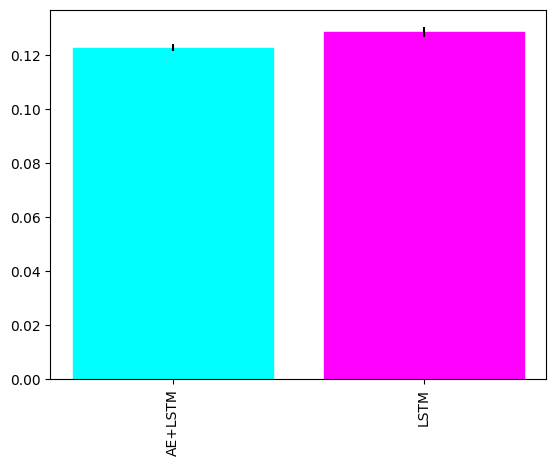

In [18]:
### PLOT AVG AND UNCERTAINTY OF RESULTS ###

bar = plt.bar([0,1], [results['AE+LSTM']['mean'], results['LSTM']['mean']], 
              yerr=[results['AE+LSTM']['std'], results['LSTM']['std']])
plt.xticks([0,1], ['AE+LSTM','LSTM'], rotation=90)
bar[0].set_color('cyan'), bar[1].set_color('magenta')
